In [1]:
# Draw PPS catchment outlines, original version, used single global identifier from PPS specs google sheet at
# https://docs.google.com/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/edit#gid=0

# Draw PPS catchment outlines-AW2 will use time-based identifiers at PPS configuration history google sheet at
# https://docs.google.com/spreadsheets/d/1Ww5qfxukYcCtuUA8vEWc86HiwxIAOIoKd2LKbOJGeE4/edit#gid=0

In [2]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [4]:
import csv, json, math, os, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [5]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

# Schools

## 9-12

In [9]:
# These are from A+ schools and didn't pan out because they've got all the streets drawn in
binarize_geojson_outlines('allegheny_county/schools/9_12.json', 
                          'allegheny_county/schools/9_12.bin')

Read 4 features from allegheny_county/schools/9_12.json
234618 segments
Created allegheny_county/schools/9_12.bin (234618 segments)


In [49]:
# These are from Alvin
# Project to WGS84 (standard lat-lon)
g = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_High.shp').to_crs(epsg=4326)


In [ ]:
g

In [ ]:
a1 = g[g.schnam.str.contains('ALLDER')]
a1

In [ ]:
pps_hs = g[g.leaid== '4219170']
pps_hs

In [ ]:
a2 = g[g.schnam.str.contains('BRASHE')]
a2

In [ ]:
a3 = g[g.schnam.str.contains('CARRICK')]
a3

In [ ]:
a4 = g[g.schnam.str.contains('PITTSBURGH PERRY HS')]
a4

In [ ]:
a=a1.append(a2.append(a3.append(a4)))
a.plot()

In [ ]:
# Inset by ~25 m
b=a.geometry.buffer(-0.0003)
b.plot()

In [90]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-9_12.geojson')
except:
    pass
b.to_file('allegheny_county/schools/alvin/alvin-9_12.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-9_12.geojson', 
                          'allegheny_county/alvin-9_12.bin')

Read 4 features from allegheny_county/schools/alvin/alvin-9_12.geojson
11861 segments
Created allegheny_county/alvin-9_12.bin (11861 segments)


## Load in all Alvin's files and subset on PPS (leaid== '4219170')

In [ ]:
# These are from Alvin
# Project to WGS84 (standard lat-lon)
m = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_Middle.shp').to_crs(epsg=4326)

In [ ]:
pps_m = m[m.leaid== '4219170']
pps_m

In [75]:
o = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_Other.shp').to_crs(epsg=4326)

In [ ]:
pps_o = o[o.leaid== '4219170']
pps_o

In [76]:
p = gpd.read_file('allegheny_county/schools/alvin/SABS_1314_Primary.shp').to_crs(epsg=4326)

In [ ]:
pps_p = p[p.leaid== '4219170']
pps_p

# Generalize

In [160]:
def accum_catchments(src,nce_arr):
    all=pd.DataFrame()

    for nce in nce_arr:
        n = src[src.ncessch == nce]
        if(n.empty):
            print "Missing %s"%(nce)
        else:
            if(all.empty):
                all = n
                #print "Got first, len = %d" % (len(all))
            else:
                all = all.append(n)
                #print "Got another, len = %d" % (len(all))
    # Inset by ~25 m
    all_eroded= all.geometry.buffer(-0.0003)
    return all_eroded

## 6-12

In [ ]:
nce_6_12 = ['421917007412','421917007345']
catch_6_12 = accum_catchments(pps_o,nce_6_12)
catch_6_12.plot()

In [171]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-6_12.geojson')
except:
    pass
catch_6_8.to_file('allegheny_county/schools/alvin/alvin-6_12.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-6_12.geojson', 
                          'allegheny_county/alvin-6_12.bin')

Read 5 features from allegheny_county/schools/alvin/alvin-6_12.geojson
9245 segments
Created allegheny_county/alvin-6_12.bin (9245 segments)


## 6-8

In [ ]:
nce_6_8 = ['421917006751','421917007132','421917000599','421917006749',
          '421917007039']
catch_6_8 = accum_catchments(pps_m,nce_6_8)
catch_6_8.plot()

In [124]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-6_8.geojson')
except:
    pass
catch_6_8.to_file('allegheny_county/schools/alvin/alvin-6_8.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-6_8.geojson', 
                          'allegheny_county/alvin-6_8.bin')

Read 5 features from allegheny_county/schools/alvin/alvin-6_8.geojson
9245 segments
Created allegheny_county/alvin-6_8.bin (9245 segments)


## K-8

In [ ]:
nce_k_8 = ['421917006769','421917006755','421917006022','421917006028',
           '421917006761','421917007468','421917006750','421917006766',
           '421917000365','421917006757']

catch_k_8 = accum_catchments(pps_p,nce_k_8)
catch_k_8.plot()

In [137]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-k_8.geojson')
except:
    pass
catch_k_8.to_file('allegheny_county/schools/alvin/alvin-k_8.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-k_8.geojson', 
                          'allegheny_county/alvin-k_8.bin')

Read 10 features from allegheny_county/schools/alvin/alvin-k_8.geojson
9644 segments
Created allegheny_county/alvin-k_8.bin (9644 segments)


## K-5

In [ ]:
nce_k_5 = ['421917003409','421917000253','421917006019','421917000330',
           '421917007411','421917006026','421917000400','421917000979',
           '421917000975','421917000363','421917000395','421917000684',
           '421917000045','421917000991','421917000600','421917006756',
           '421917006747','421917000255']
catch_k_5 = accum_catchments(pps_p,nce_k_5)
catch_k_5.plot()

In [164]:
try:
    os.unlink('allegheny_county/schools/alvin/alvin-k_5.geojson')
except:
    pass
catch_k_8.to_file('allegheny_county/schools/alvin/alvin-k_5.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/alvin-k_5.geojson', 
                          'allegheny_county/alvin-k_5.bin')

Read 18 features from allegheny_county/schools/alvin/alvin-k_5.geojson
18845 segments
Created allegheny_county/alvin-k_5.bin (18845 segments)


# Unified 2015/2016 data

In [5]:
# Found newer files that have all levels together from https://nces.ed.gov/programs/edge/sabs
# Downloaded https://nces.ed.gov/programs/edge/data/SABS_1516.zip to
# hal15:~/uwsgi/dotmaptiles/data-visualization-tools/examples/lodes/allegheny_county/schools/alvin
p_1516 = gpd.read_file('allegheny_county/schools/alvin/SABS_1516/SABS_1516.shp').to_crs(epsg=4326)
p_1516['ncessch'] = p_1516['ncessch'].astype(numpy.str)

In [6]:
pps_1516_raw = p_1516[p_1516.leaid== '4219170']
pps_1516=pps_1516_raw.copy()
pps_1516=pps_1516.set_index('ncessch')


# PPS specs google sheet

In [6]:
# Read in PPS specs google sheet
#  https://docs.google.com/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/edit#gid=0
pps_specs_path = "https://docs-proxy.cmucreatelab.org/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/export?format=csv&gid=0"
#pps_specs_csv_all = pd.read_csv(pps_specs_path,dtype={'ncessch':np.int64,'nbhd':np.str})
pps_specs_csv_all = pd.read_csv(pps_specs_path,dtype={'ncessch':np.str,'nbhd':np.str},keep_default_na=False)

# Take the subset that we know the ncessch value for
pps_specs_csv_known = pps_specs_csv_all[(pps_specs_csv_all.nbhd!= '') & (pps_specs_csv_all.ncessch!='')]
pps_specs_csv_known

# Set index to ncessch
pps_specs_csv_known=pps_specs_csv_known.copy().set_index('ncessch')

# Take the subset that are neighborhood schools
pps_specs_csv_nbhd = pps_specs_csv_known[pps_specs_csv_known.nbhd== 'y']
#pps_specs_csv_nbhd

In [7]:
# Create a column for category: 0=non-neighborhood, 1=neighborhood, 2=community, 3=special
pps_specs_csv_known['category']=pps_specs_csv_known[['nbhd', 'community']].apply(lambda x: (1 if x[0]=='y' else 0)+(1 if x[1]=='y' else 0) , axis=1)


In [ ]:
pps_specs_csv_known[['Name','category']]

In [329]:
# Create a table that only contains the PPS neighborhood schools and has all the columns from both the 
# geopandas and csv
pps_1516_nhbd = pd.merge(pps_1516, pps_specs_csv_nbhd, on='ncessch', how='inner')
#pps_1516_nhbd

In [330]:
pre_ks = pps_1516_nhbd[pps_1516_nhbd.gslo == 'PK']
#pre_ks

In [ ]:
# Inset by ~25 m
pre_ks_eroded= pre_ks.geometry.buffer(-0.0003)
pre_ks_eroded.plot()

In [332]:
try:
    os.unlink('allegheny_county/schools/alvin/schools_1516-prek.geojson')
except:
    pass
pre_ks_eroded.to_file('allegheny_county/schools/alvin/schools_1516-prek.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/schools/alvin/schools_1516-prek.geojson', 
                          'allegheny_county/schools_1516-prek.bin')

Read 19 features from allegheny_county/schools/alvin/schools_1516-prek.geojson
18004 segments
Created allegheny_county/schools_1516-prek.bin (18004 segments)


In [333]:
def write_schools_geometry(df, json_path, bin_path):
    # Inset by ~25 m
    df_eroded= df.geometry.buffer(-0.0003)
    df.plot()
    try:
        os.unlink(json_path)
    except:
        pass
    df_eroded.to_file(json_path, driver="GeoJSON")
    binarize_geojson_outlines(json_path, 
                              bin_path)

In [411]:
def write_schools_csv(df, val_colname, include_sizes, include_latlon, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    for i in range(0,len(df.index)):
        # Make sure we know lat/lon
        if(include_latlon and (pd.isnull(df['Latitude'][i]) or df['Latitude'][i]=='' or
            pd.isnull(df['Longitude'][i]) or df['Longitude'][i]=='')):
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row -- size is 20 if not set, or size if set
        size_row=[str(df.index[i])]
        if(include_latlon):
            size_row.append(df['Latitude'][i])
            size_row.append(df['Longitude'][i])

        for year in date_range:
            #if(df['Size'][i]!=''):
            if(not pd.isnull(df['Size'][i]) and df['Size'][i]!=''):
                size_row.append(int(df['Size'][i]))
            else:
                size_row.append(20)
        
        # Bubble color row -- value depends on status
        color_row=[str(df.index[i])]
        if(include_latlon):
            color_row.append(df['Latitude'][i])
            color_row.append(df['Longitude'][i])

        for year in date_range:
            color_val=0
            if(not pd.isnull(df[val_colname][i]) and df[val_colname][i]!=''):
                color_val=df[val_colname][i]
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [412]:
write_schools_csv(pre_ks,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-prek.csv')
write_schools_csv(pre_ks,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-prek.csv')


## 9-12

In [ ]:
hs = pps_1516_nhbd[pps_1516_nhbd.Type == '9-12']
write_schools_geometry(hs, 'allegheny_county/schools/alvin/schools_1516-9_12.geojson', 
                       'allegheny_county/schools_1516-9_12.bin')
write_schools_csv(hs,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-9_12.csv')
write_schools_csv(hs,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-9_12.csv')

In [414]:
## K-5

In [ ]:
K5 = pps_1516_nhbd[pps_1516_nhbd.Type == 'K-5']
write_schools_geometry(K5, 'allegheny_county/schools/alvin/schools_1516-k_5.geojson', 
                       'allegheny_county/schools_1516-k_5.bin')
write_schools_csv(K5,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-k_5.csv')
write_schools_csv(K5,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-k_5.csv')

In [416]:
## K-8

In [ ]:
K8 = pps_1516_nhbd[pps_1516_nhbd.Type == 'K-8']
write_schools_geometry(K8, 'allegheny_county/schools/alvin/schools_1516-k_8.geojson', 
                       'allegheny_county/schools_1516-k_8.bin')
write_schools_csv(K8,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-k_8.csv')
write_schools_csv(K8,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-k_8.csv')

In [418]:
## 6-8

In [ ]:
m_68 = pps_1516_nhbd[pps_1516_nhbd.Type == '6-8']
write_schools_geometry(m_68, 'allegheny_county/schools/alvin/schools_1516-6_8.geojson', 
                       'allegheny_county/schools_1516-6_8.bin')
write_schools_csv(m_68,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-6_8.csv')
write_schools_csv(m_68,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-6_8.csv')

In [420]:
## 6-12

In [ ]:
m_612 = pps_1516_nhbd[pps_1516_nhbd.Type == '6-12']
write_schools_geometry(m_612, 'allegheny_county/schools/alvin/schools_1516-6_12.geojson', 
                       'allegheny_county/schools_1516-6_12.bin')
write_schools_csv(m_612,'chronic_absences',True,True,'allegheny_county/schools_1516-bubbles-6_12.csv')
write_schools_csv(m_612,'chronic_absences',False,False,'allegheny_county/schools_1516-chor-6_12.csv')


# PPS Configuration Mapping

In [ ]:
# Read in PPS configuration history google sheet
#  https://docs.google.com/spreadsheets/d/1Ww5qfxukYcCtuUA8vEWc86HiwxIAOIoKd2LKbOJGeE4/edit#gid=0

pps_config_path = 'https://docs-proxy.cmucreatelab.org/spreadsheets/d/1Ww5qfxukYcCtuUA8vEWc86HiwxIAOIoKd2LKbOJGeE4/export?format=csv&gid=0'
pps_config_csv_all = pd.read_csv(pps_config_path,dtype={'ncessch':np.str,'nbhd':np.str,'vocational':np.str},keep_default_na=False)
# Create a column for category: 0=non-neighborhood, 1=neighborhood, 2=community
pps_config_csv_all['category']=pps_config_csv_all[['nbhd', 'community', 'sp_ed']].apply(lambda x: (4 if x[2]=='y' else 1+(1 if x[0]=='y' else 0)+(1 if x[1]=='y' else 0)) , axis=1)
pps_config_csv_all[['LocID','Type','start_year','end_year','nbhd', 'community','sp_ed','category']]

In [ ]:
pps_config_csv_all[pps_config_csv_all['community']=='y']

In [ ]:
pps_config_csv_all[pps_config_csv_all.category>3][['LocID','Type','start_year','end_year','nbhd', 'community','sp_ed','category']]

In [279]:
def pps_config(year):
    year=int(year)
    df = pps_config_csv_all[(pps_config_csv_all['start_year']<=year) & (pps_config_csv_all['end_year']>year)]
    df = df.set_index('LocID')
    return df

gradespec_re = re.compile('^(.+)\s+((PreK)|K|(\d+))\s*\-\s*(\d+)\s*$')
def strip_gradespec(sname):
    m = gradespec_re.match(sname)
    if(m):
        # Did contain a gradespec
        return [m.group(1), m.group(2), m.group(5)]
    else:
        # Did not contain a gradespec, leave it alone
        return [sname]
    
def locid_to_latlon(locid):
    df = pps_config_csv_all[(pps_config_csv_all['LocID']==locid)].iloc[0]
    return (df['Latitude'],df['Longitude'])

def schoolname_to_locid(schoolname, stype, year):
    pps_cdf = pps_config(year)
    # Strip grade spec from end of name if present
    gs_ret = strip_gradespec(schoolname)
    backup_stype=None
    if(len(gs_ret)>1):
        # There was a gradespec, hold onto it in case we need it
        backup_stype = "%s-%s"%(gs_ret[1], gs_ret[2])
    sname = gs_ret[0]
                             
    # Get rid of Pittsburgh and Academy if present
    sname = re.sub('\s+Academy', '', sname)
    sname = re.sub('Pittsburgh\s+', '', sname)
    # Change Sci-Tech to Science and Technology Academy if present
    sname = re.sub('Sci-Tech', 'Science and Technology Academy', sname)
    name_match_vec = (pps_cdf.Name.str.contains("^%s"%(sname),regex=True,case=False))
    if(stype):
        # If stype contains K or PreK, try both
        alt_match_str = None
        if('K' in stype):
            if('PreK' in stype):
                alt_match_str = re.sub('PreK', 'K', stype)
            else:
                alt_match_str = re.sub('K', 'PreK', stype)
        if(alt_match_str):
            name_match_vec = name_match_vec & ((pps_cdf.Type==stype) | (pps_cdf.Type==alt_match_str))
        else:
            name_match_vec = name_match_vec & (pps_cdf.Type==stype)
    matching_row = pps_cdf[name_match_vec]
    if(len(matching_row)==1):
        return matching_row.iloc[0].name
    elif(len(matching_row)>1 and not stype and backup_stype):
        # Try with backup_stype
        return(schoolname_to_locid(sname,backup_stype,year))
    else:
        locid_arr=None
        if(len(matching_row)>1):
            locid_arr=list(matching_row.index)
        print "Error %s, %s, %s matches %d rows: %r"%(schoolname, stype, year, len(matching_row), locid_arr)
        return None

### Testing of pps_spec

In [184]:
print strip_gradespec('Arsenal 6-8')
print strip_gradespec('Pittsburgh Westinghouse Academy 6-12')
print strip_gradespec('Brashear High School')
print strip_gradespec('Concord PreK-5')
print strip_gradespec('Lincoln K-5')
print strip_gradespec('Pittsburgh Roosevelt PreK -5')
print strip_gradespec('Sci-Tech')

['Arsenal', '6', '8']
['Pittsburgh Westinghouse Academy', '6', '12']
['Brashear High School']
['Concord', 'PreK', '5']
['Lincoln', 'K', '5']
['Pittsburgh Roosevelt', 'PreK', '5']
['Sci-Tech']


In [376]:
year=2012
print schoolname_to_locid('Arsenal 6-8', None, year)
print schoolname_to_locid('Westinghouse Academy 6-12', None, year)
print schoolname_to_locid('Brashear High School', None, year)
print schoolname_to_locid('Concord PreK-5', None, year)
print schoolname_to_locid('Lincoln K-5', None, year)
print schoolname_to_locid('Pittsburgh Roosevelt PreK -5', None, year)
print schoolname_to_locid('Science And Technology Academy', None, year)
print schoolname_to_locid('Concord', 'K-5', 2013)

Arsenal 6-8
Westinghouse
Brashear
Concord-2
Lincoln
Roosevelt
Science and Technology Academy
Concord-2


In [204]:
nc

In [43]:
locid_to_latlon('Science and Technology Academy')

('40.443313', '-79.957038')

In [ ]:
pps_config('2011')

# A+ Schools data files

In [11]:
def schoolname_to_ncessch(schoolname, stype):
    name_match_vec = (pps_specs_csv_known.Name.str.contains("^%s"%(schoolname),regex=True))
    if(stype):
        name_match_vec = name_match_vec & (pps_specs_csv_known.Type==stype)
    matching_row = pps_specs_csv_known[name_match_vec]
    if(len(matching_row)==1):
        return matching_row.iloc[0].name
    else:
        return None
    

# Enrollment

In [12]:
enrollment_map={}
enrollment_colnames=['School Name','Total enrollment','Black enrollment','White enrollment','Asian enrollment','Hispanic enrollment','Other enrollment']

In [280]:
# Create list of nsessch values for combined 9-12, 6-8, and K-5.  Put both 9-12 and 6-12 in 9-12, all three of K-8, 6-12, and 6-8 in 6-8, and both K-5 and K-8 in K-5
cstype_map = {'9-12':['9-12','6-12','7-12','4-12','K-12','PreK-12','5-12','8-12'],
             '6-8':['PreK-8', 'K-8','6-12','6-8','7-12','4-12','K-12','PreK-12''5-12','PreK-7','8-12','PreK-6'],
             'K-5':['PreK-5','K-5','PreK-8','K-8','4-12','K-12','PreK-12','5-12','PreK-6','K-6','PreK-7']}
# For each combined school type, hold onto a list of nsessch values for it.  The ones from 6-12 and K-8 will each appear multiple times.
nsessch_map = {}

# Populate nsessch_map for each combined school type
for cstype_i in cstype_map:
    cstype_match_vec_i = pd.Series(False,pps_specs_csv_known.index)
    for stype_j in cstype_map[cstype_i]:
        stype_match_vec_j=(pps_specs_csv_known.Type==stype_j)                                               
        cstype_match_vec_i = cstype_match_vec_i | stype_match_vec_j
    
    nsessch_map[cstype_i] = list(pps_specs_csv_known[cstype_match_vec_i].index)

In [281]:
# Make sure we got everything
all_cstypes= list(pps_config_csv_all['Type'].unique())
inc_cstypes = set()
for cstype_i in cstype_map:
    inc_cstypes=inc_cstypes.union(cstype_map[cstype_i])
missing_cstypes = set(all_cstypes)-inc_cstypes
missing_cstypes

{'PreK'}

In [73]:
# Deal with change to per-year pps_config
def get_locids_for_cstype(cstype, year):
    pps_cdf = pps_config(year)

    cstype_match_vec_i = pd.Series(False,pps_cdf.index)
    for stype_j in cstype_map[cstype]:
        stype_match_vec_j=(pps_cdf.Type==stype_j)                                               
        cstype_match_vec_i = cstype_match_vec_i | stype_match_vec_j
    
    return list(pps_cdf[cstype_match_vec_i].index)

In [ ]:
get_locids_for_cstype('K-5', 2016)

### 2012 Enrollment? 

In [224]:
# In 2012 folder at A+ Schools, updated 10/16/12: 
# https://www.dropbox.com/home/Report%20to%20the%20Community/2012?preview=enroll_att_lunch_etc_12+FINAL+v2.xlsx
path_aps_2012="allegheny_county/schools/aplus_schools/enroll_att_lunch_etc_12 FINAL v2.xlsx"
xls_aps_2012 = pd.ExcelFile(path_aps_2012, header=None, index_col=None)
xls_aps_2012.sheet_names

[u'elementary',
 u'K8',
 u'middle',
 u'6-12',
 u'highschool',
 u'definitions',
 u'all schools']

In [ ]:
# Special case this one to name the first two columns.  If leftmost columns have no name, they get used as a multi-index
colnames_2012=['Name',"Type", u'tch_totn12', u'tch_pctatt12',
                     u'attend12', u'enroll12', u'pct_black12', u'pct_white12',
                     u'pct_multi12', u'pct_asian12', u'pct_hisp12', u'pct_NA12',
                     u'pct_oth12', u'lunch_12', u'inc_per100_']

df_aps_2012=pd.read_excel(xls_aps_2012, 'all schools', index_col=None, header=None,skiprows=1, names=colnames_2012)
df_aps_2012

In [ ]:
remap_schoolnames_2012 = {}
# Check all the schools map to LocID values
df = df_aps_2012
df=df[~pd.isna(df.Name)]
#df['Name']=df['Name'].str.replace("Pittsburgh ","").copy()
#.replace("((K)|(PreK)|(\d+))-(\d+)","",regex=True)
for i in range(0,len(df)):
    schoolname = df.iloc[i]['Name'].strip()
    if(schoolname in remap_schoolnames_2012):
        schoolname = remap_schoolnames_2012[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2012)
    print "%r %r" % (schoolname,locid)
df_aps_2012=df

In [638]:
# Create LocID index
df = df_aps_2012
1516df = df[~pd.isna(df.LocID)].copy()
df = df.set_index('LocID')
df_aps_2012=df

In [ ]:
df_aps_2012

In [640]:
# Create normalized values for enrollment_map
df = df_aps_2012
df['School Name']=df['Name']
df['Black enrollment']=((df['enroll12']*(df['pct_black12'].fillna(0)))).astype(int)
df['White enrollment']=((df['enroll12']*(df['pct_white12'].fillna(0)))).astype(int)
df['Asian enrollment']=((df['enroll12']*(df['pct_asian12'].fillna(0)))).astype(int)
df['Hispanic enrollment']=((df['enroll12']*(df['pct_hisp12'].fillna(0)))).astype(int)    
df['Total enrollment']=df['enroll12'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2012'] = df[enrollment_colnames]


In [ ]:
enrollment_map['2012']

### 2013 Enrollment

In [146]:
path_aps_2013="allegheny_county/schools/aplus_schools/2013 Enrollment   college readiness AtoZ.xlsx"
xls_aps_2013 = pd.ExcelFile(path_aps_2013)
df_aps_2013_map={}
for sname in xls_aps_2013.sheet_names:
    df_aps_2013_map[sname]=pd.read_excel(xls_aps_2013, sname,header=1)

In [ ]:
# Check all the schools map to LocID values
for stype in df_aps_2013_map.keys():
    df = df_aps_2013_map[stype]
    for i in range(0,len(df)):
        schoolname = df.iloc[i]['School Name'].strip()
        if(schoolname == 'DISTRICT'):
            # End of list, break
            break

        locid = schoolname_to_locid(schoolname, stype, 2013)
        print "%s %s %r" % (schoolname,stype,locid)

In [ ]:
df_aps_2013_map['K-5']

In [642]:
# Create LocID index
for stype in df_aps_2013_map.keys():
    df = df_aps_2013_map[stype]
    df['LocID']=df['School Name'].map(lambda sname: schoolname_to_locid(sname.strip(), stype,2013))
    df = df[~pd.isna(df.LocID)].copy()
    df = df.set_index('LocID')
    df_aps_2013_map[stype]=df

In [643]:
# Create normalized values for enrollment_map
enrollment_2013_map={}
for stype in df_aps_2013_map.keys():
    df = df_aps_2013_map[stype]
    df['Type']=stype
    df['Black enrollment']=((df['Total enrollment']*(df['% Black'].fillna(0)))/100.0).astype(int)
    df['White enrollment']=((df['Total enrollment']*(df['% White'].fillna(0)))/100.0).astype(int)
    df['Asian enrollment']=((df['Total enrollment']*(df['% Asian'].fillna(0)))/100.0).astype(int)
    df['Hispanic enrollment']=((df['Total enrollment']*(df['% Hispanic'].fillna(0)))/100.0).astype(int)    
    df['Total enrollment']=df['Total enrollment'].astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    enrollment_2013_map[stype]=df[enrollment_colnames]
enrollment_map['2013'] = pd.concat(enrollment_2013_map.values())

In [ ]:
enrollment_map['2013']

### 2014 Enrollment

In [154]:
path_aps_2014="allegheny_county/schools/aplus_schools/2014 Enrollment   college readiness AtoZ.xlsx"
xls_aps_2014 = pd.ExcelFile(path_aps_2014)
df_aps_2014_map={}
for sname in xls_aps_2014.sheet_names:
    df_aps_2014_map[sname]=pd.read_excel(xls_aps_2014, sname,header=1)


In [ ]:
# Check all the schools map to LocID values
for stype in df_aps_2014_map.keys():
    df = df_aps_2014_map[stype]
    for i in range(0,len(df)):
        schoolname = df.iloc[i]['School Name'].strip()
        if(schoolname == 'DISTRICT'):
            # End of list, break
            break

        locid = schoolname_to_locid(schoolname, stype, 2014)
        print "%s %s %r" % (schoolname,stype,locid)

In [645]:
# Create LocID index
for stype in df_aps_2014_map.keys():
    df = df_aps_2014_map[stype]
    df['LocID']=df['School Name'].map(lambda sname: schoolname_to_locid(sname.strip(), stype, 2014))
    df = df[~pd.isna(df.LocID)].copy()
    df = df.set_index('LocID')
    df_aps_2014_map[stype]=df

In [646]:
# Create normalized values for enrollment_map
enrollment_2014_map={}
for stype in df_aps_2014_map.keys():
    df = df_aps_2014_map[stype]
    df['Type']=stype
    df['Black enrollment']=((df['Total enrollment']*(df['% Black'].fillna(0)))/100.0).astype(int)
    df['White enrollment']=((df['Total enrollment']*(df['% White'].fillna(0)))/100.0).astype(int)
    df['Asian enrollment']=((df['Total enrollment']*(df['% Asian'].fillna(0)))/100.0).astype(int)
    df['Hispanic enrollment']=((df['Total enrollment']*(df['% Hispanic'].fillna(0)))/100.0).astype(int)    
    df['Total enrollment']=df['Total enrollment'].astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    enrollment_2014_map[stype]=df[enrollment_colnames]
enrollment_map['2014'] = pd.concat(enrollment_2014_map.values())


In [709]:
# Fill in gaps from DiscoverPPS
enrollment_map['2014'].loc['Conroy']=['Conroy',90+64+1+3+6,90,64,1,3,6]
enrollment_map['2014'].loc['Oliver']=['Oliver',91+15+1+8,91,15,0,1,8]
enrollment_map['2014'].loc['Pioneer']=['Pioneer',28+34+3+1+4,28,34,3,1,4]

In [ ]:
enrollment_map['2014']

### 2015 Enrollment

In [160]:
path_aps_2015="allegheny_county/schools/aplus_schools/School Enrollment File 2015-16, includes ethnicity and special education.xlsx"
xls_aps_2015 = pd.ExcelFile(path_aps_2015)
xls_aps_2015.sheet_names


[u'Data Notes',
 u'Enrollment As of Oct 2015',
 u'dm edited',
 u'Race IEP Enroll as of Oct 2015',
 u'dm edited 3',
 u'Enrollment As of June 2016',
 u'dm edited 2',
 u'Race IEP Enroll as of June 2016',
 u'Sheet1']

In [161]:
df_aps_2015=pd.read_excel(xls_aps_2015,'Enrollment As of Oct 2015')

In [162]:
# Screen out per-grade and District rows
df_aps_2015 = df_aps_2015[(~df_aps_2015['School/Grade'].str.contains('^[\dK]+')) & (~(df_aps_2015['School/Grade']=='District'))]

In [ ]:
df_aps_2015

In [ ]:
#remap_schoolnames_2015={'Science And Technology Academy':'Sci-Tech', 'Montessori PreK-5':'Montessori', 'Westinghouse Academy 6-12':'Westinghouse 6-12'}
remap_schoolnames_2015={}
# Check all the schools map to LocID values
df = df_aps_2015
for i in range(0,len(df)):
    schoolname = df.iloc[i]['School/Grade'].strip()
    if(schoolname in remap_schoolnames_2015):
        schoolname = remap_schoolnames_2015[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2015)
    print "%s %r" % (schoolname,locid)

In [648]:
# Create LocID index
df = df_aps_2015
df['LocID']=df['School/Grade'].map(lambda sname: schoolname_to_locid(sname.strip() if(not sname in remap_schoolnames_2015) else remap_schoolnames_2015[sname], None,2015))
df = df[~pd.isna(df.LocID)].copy()
df = df.set_index('LocID')
df_aps_2015=df

In [649]:
# Create normalized values for enrollment_map
df = df_aps_2015
df['School Name']=df['School/Grade']
df['Black enrollment']=df['# African American'].astype(int)
df['White enrollment']=df['# White'].astype(int)
df['Asian enrollment']=df['# Asian (not Pacific Islander)'].astype(int)
df['Hispanic enrollment']=df['# Hispanic'].astype(int)
df['Total enrollment']=df['Total Enrollment'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2015'] = df[enrollment_colnames]

In [ ]:
enrollment_map['2015']

### Enrollment 2016

In [190]:
path_aps_2016='allegheny_county/schools/aplus_schools/October 2016 ED enrollment and June 2017 Enrollments 10-12-17.xlsx'
xls_aps_2016 = pd.ExcelFile(path_aps_2016)
xls_aps_2016.sheet_names

[u'Oct 2016 ED',
 u'JUNE17 ENROLL by RACE',
 u'JUNE17 ED by GRADE',
 u'JUNE17 Gifted, IEP breakdowns']

In [191]:
df_aps_2016=pd.read_excel(xls_aps_2016,'JUNE17 ENROLL by RACE', header=6)

In [192]:
# Screen out per-grade and District rows
df_aps_2016=df_aps_2016[(~df_aps_2016['School Name'].fillna('').str.contains('^[\dK]+').fillna(True)) & (~(df_aps_2016['School Name']=='Grand Total')) & (~(df_aps_2016['School Name']=='(blank)'))]

In [ ]:
#remap_schoolnames_2016={'Science And Technology Academy':'Sci-Tech', 'Montessori PreK-5':'Montessori', 'Westinghouse Academy 6-12':'Westinghouse 6-12'}
remap_schoolnames_2016={}
# Check all the schools map to ncessch values
df = df_aps_2016
for i in range(0,len(df)):
    schoolname = df.iloc[i]['School Name'].strip()
    if(schoolname in remap_schoolnames_2016):
        schoolname = remap_schoolnames_2016[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2016)
    print "%s %r" % (schoolname,locid)

In [651]:
# Create LocID index and get rid of duplicates
df = df_aps_2016
df['LocID']=df['School Name'].map(lambda sname: schoolname_to_locid(sname.strip() if(not sname in remap_schoolnames_2016) else remap_schoolnames_2016[sname], None, 2016))
df = df[~pd.isna(df.LocID)].copy()
df = df.set_index('LocID')
df = df[~df.index.duplicated()].copy()
df_aps_2016=df

In [ ]:
# Create normalized values for enrollment_map
df = df_aps_2016
df['Black enrollment']=df['AA'].astype(int)
df['White enrollment']=df['W'].astype(int)
df['Asian enrollment']=df['A'].fillna(0).astype(int)
df['Hispanic enrollment']=df['H'].fillna(0).astype(int)
df['Total enrollment']=(df['AA'].fillna(0)+df['AI'].fillna(0)+df['A'].fillna(0)+df['H'].fillna(0)+df['MR'].fillna(0)+df['NHPI'].fillna(0)+df['W'].fillna(0)).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2016'] = df[enrollment_colnames]

In [708]:
# Fill in gaps from DiscoverPPS
enrollment_map['2016'].loc['Conroy']=['Conroy',102+74+0+3+6,102,74,0,3,6]
enrollment_map['2016'].loc['Oliver']=['Oliver',85+7+3,85,7,0,0,3]
enrollment_map['2016'].loc['Pioneer']=['Pioneer',33+34+4+2+3,33,34,4,2,3]
enrollment_map['2016'].loc['King']=['King',422+15+0+10+53,422,15,0,10,53]

/home/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
enrollment_map['2016']

### Enrollment 2017

In [393]:
path_aps_2017="allegheny_county/schools/aplus_schools/10-18-2017 Enrollment Report, updated with ED info.xlsx"
xls_aps_2017 = pd.ExcelFile(path_aps_2017)
xls_aps_2017.sheet_names

[u'Enrollment Report - Ethnicities',
 u'ED Membership ',
 u'IEP Membership',
 u' ELL Membership',
 u'Gifted Membership']

In [394]:
df_aps_2017=pd.read_excel(xls_aps_2017,'Enrollment Report - Ethnicities')

In [395]:
# Screen out per-grade and District rows
df_aps_2017=df_aps_2017[(~df_aps_2017['School/Grade'].fillna('').str.contains('^[\dK]+').fillna(True)) & (~(df_aps_2017['School/Grade']=='District'))]

In [ ]:
#remap_schoolnames_2017={'Science And Technology Academy':'Sci-Tech', 'Montessori PreK-5':'Montessori', 'Westinghouse Academy 6-12':'Westinghouse 6-12'}
remap_schoolnames_2017={}
# Check all the schools map to LocID values
df = df_aps_2017
for i in range(0,len(df)):
    schoolname = df.iloc[i]['School/Grade'].strip()
    if(schoolname in remap_schoolnames_2017):
        schoolname = remap_schoolnames_2017[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2017)
    print "%s %r" % (schoolname,locid)

In [653]:
# Create LocID index
df = df_aps_2017.copy()
df['LocID']=df['School/Grade'].map(lambda sname: schoolname_to_locid(sname.strip() if(not sname in remap_schoolnames_2017) else remap_schoolnames_2017[sname], None, 2017))
df = df[~pd.isna(df.LocID)].copy()
df = df.set_index('LocID')
df_aps_2017=df

In [ ]:
# Create normalized values for enrollment_map
df = df_aps_2017
df['School Name']=df['School/Grade']
df['Black enrollment']=df['AA'].astype(int)
df['White enrollment']=df['White'].astype(int)
df['Asian enrollment']=df['Asian'].fillna(0).astype(int)
df['Hispanic enrollment']=df['Hispanic'].fillna(0).astype(int)
df['Total enrollment']=df['Total Enrollment'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
enrollment_map['2017'] = df[enrollment_colnames]
enrollment_map['2017']

### Write CSVs

In [299]:
def write_enrollment_csv(locid_set, size_population, val_map, val_colname, include_sizes, include_latlon, out_path):
    date_range = sorted(val_map.keys())
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    # Build map of pps_config(year) for each year we're processing
    #pps_config_map={}
    #for year in date_range:
    #    pps_config_map[year]=pps_config(year)

    for lid in locid_set:
        # Make sure we know lat/lon
        lat,lon = locid_to_latlon(lid)
        if(include_latlon and (pd.isnull(lat) or lat=='' or (pd.isnull(lon) or lon==''))):
            print "Don't have lat/lon for %s" % (lid)
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row label is LocID
        size_row=[lid]
        if(include_latlon):
            size_row.append(lat)
            size_row.append(lon)

        for year in date_range:
            # Get size from the value of size_population, which may be Total, Black, White, Asian, Hispanic, or Other
            size_colname='{} enrollment'.format(size_population)
            size_val=0.1
            try:
                if(not size_colname in list(enrollment_map[year]) and 
                   not size_colname in list(val_map[year])):
                    print "No %r column for %s" % (size_colname, year)
                elif(not lid in enrollment_map[year].index and 
                     not lid in val_map[year].index):
                    print "No enrollment data for %s in %s" % (lid, year)
                else:
                    if size_colname in list(enrollment_map[year]):
                        size_val = enrollment_map[year].loc[lid][size_colname] 
                    else:
                        size_val = val_map[year].loc[lid][size_colname]
                    if(not size_val):
                        print "No %s for %s for %s" % (size_colname, year, lid)
                        size_val=0
            except Exception as e:
                print "Error processing %s for %s for %s: %s" % (size_colname, year, lid, str(e))
                               
            size_row.append(size_val)
        
        # Bubble color row
        color_row=[lid]
        if(include_latlon):
            color_row.append(lat)
            color_row.append(lon)

        for year in date_range:
            color_val=0
            if(year in val_map.keys()):
                val_df = val_map[year]
                if(lid in val_df.index and val_colname in list(val_df)):
                    color_val = val_df.loc[lid][val_colname]
                else:
                    print "No value for %s, %s, %s" % (lid, year, val_colname)
                    
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [44]:
# Create a map for each of the years we have enrollment data for to pps_config so we can use general categorical info for coloring maps
pps_config_map={}

for year in enrollment_map.keys():
    pps_config_map[year] = pps_config(year)

In [ ]:
sorted(enrollment_map.keys())

In [ ]:
sorted(pps_config_map.keys())

In [ ]:
# Output population files
print "Processing enrollment csvs covering %r" % (enrollment_map.keys())
for population in ['Total', 'White', 'Black']:
    for cstype in cstype_map.keys():
        locid_set=set()
        # Accumulate the locids that cover any of the enrollment years
        for year in enrollment_map.keys():
            locid_set = locid_set.union(set(get_locids_for_cstype(cstype,year)))
        print "%s: %r" % (cstype, locid_set)
        write_enrollment_csv(locid_set, population, enrollment_map, '{} enrollment'.format(population), False, True, 'allegheny_county/schools_{0}_enrollment-g_{1}.csv'.format(population.lower(),cstype))

In [ ]:
for cstype in cstype_map.keys():
    locid_set=set()
    # Accumulate the locids that cover any of the enrollment years
    for year in enrollment_map.keys():
        locid_set = locid_set.union(set(get_locids_for_cstype(cstype,year)))
    print "%s: %r" % (cstype, locid_set)
    write_enrollment_csv(locid_set, population, pps_config_map, 'category', True, True, 'allegheny_county/schools_{0}_category-g.csv'.format(cstype))

# Randy's processed NCES files

In [165]:
nces_2015_col_remap={'School Name':'SCH_NAME','Zip':'MZIP','Latitude':'LAT1516','Longitude':'LON1516','Total enrollment':'TOTAL',
                     'Black enrollment':'BL','White enrollment':'WH',
                     'Asian enrollment':'AS','Hispanic enrollment':'HI',
                     'LEAID':'LEAID', 'STATUS':'SY_STATUS', 'TYPE':'SCH_TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'}

nces_2014_col_remap={'School Name':'SCH_NAME','Zip':'MZIP','Latitude':'LATCODE','Longitude':'LONGCODE','Total enrollment':'TOTAL',
                     'Black enrollment':'BL','White enrollment':'WH',
                     'Asian enrollment':'AS','Hispanic enrollment':'HI',
                     'LEAID':'LEAID', 'STATUS':'SY_STATUS', 'TYPE':'SCH_TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'
                    }

nces_2013_col_remap={'School Name':'SCHNAM','Zip':'MZIP','Latitude':'LATCOD','Longitude':'LONCOD','Total enrollment':'TOTETH',
                     'Black enrollment':'BLACK','White enrollment':'WHITE',
                     'Asian enrollment':'ASIAN','Hispanic enrollment':'HISP',
                     'LEAID':'LEAID', 'STATUS':'STATUS', 'TYPE':'TYPE', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO', 'GSHI':'GSHI'
                    }

nces_2009_col_remap={'School Name':'SCHNAM09','Zip':'MZIP09','Latitude':'LATCOD09','Longitude':'LONCOD09','Total enrollment':'TOTETH09',
                     'Black enrollment':'BLACK09','White enrollment':'WHITE09',
                     'Asian enrollment':'ASIAN09','Hispanic enrollment':'HISP09',
                     'LEAID':'LEAID', 'STATUS':'STATUS09', 'TYPE':'TYPE09', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO09', 'GSHI':'GSHI09'
                    }

nces_2008_col_remap={'School Name':'SCHNAM08','Zip':'MZIP08','Latitude':'LATCOD08','Longitude':'LONCOD08','Total enrollment':'TOTETH08',
                     'Black enrollment':'BLACK08','White enrollment':'WHITE08',
                     'Asian enrollment':'ASIAN08','Hispanic enrollment':'HISP08',
                     'LEAID':'LEAID', 'STATUS':'STATUS08', 'TYPE':'TYPE08', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO08', 'GSHI':'GSHI08'
                    }

nces_2007_col_remap={'School Name':'SCHNAM07','Zip':'MZIP07','Latitude':'LATCOD07','Longitude':'LONCOD07','Total enrollment':'TOTETH07',
                     'Black enrollment':'BLACK07','White enrollment':'WHITE07',
                     'Asian enrollment':'ASIAN07','Hispanic enrollment':'HISP07',
                     'LEAID':'LEAID', 'STATUS':'STATUS07', 'TYPE':'TYPE07', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO07', 'GSHI':'GSHI07'
                    }

nces_2006_col_remap={'School Name':'SCHNAM06','Zip':'MZIP06','Latitude':'LATCOD06','Longitude':'LONCOD06','Total enrollment':'TOTETH06',
                     'Black enrollment':'BLACK06','White enrollment':'WHITE06',
                     'Asian enrollment':'ASIAN06','Hispanic enrollment':'HISP06',
                     'LEAID':'LEAID', 'STATUS':'STATUS06', 'TYPE':'TYPE06', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO06', 'GSHI':'GSHI06'
                    }

nces_2005_col_remap={'School Name':'SCHNAM05','Zip':'MZIP05','Latitude':'LATCOD05','Longitude':'LONCOD05','Total enrollment':'TOTETH05',
                     'Black enrollment':'BLACK05','White enrollment':'WHITE05',
                     'Asian enrollment':'ASIAN05','Hispanic enrollment':'HISP05',
                     'LEAID':'LEAID', 'STATUS':'STATUS05', 'TYPE':'TYPE05', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO05', 'GSHI':'GSHI05'
                    }

nces_2004_col_remap={'School Name':'SCHNAM04','Zip':'MZIP04','Latitude':'LATCOD04','Longitude':'LONCOD04','Total enrollment':'TOTETH04',
                     'Black enrollment':'BLACK04','White enrollment':'WHITE04',
                     'Asian enrollment':'ASIAN04','Hispanic enrollment':'HISP04',
                     'LEAID':'LEAID', 'STATUS':'STATUS04', 'TYPE':'TYPE04', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO04', 'GSHI':'GSHI04'
                    }

nces_2003_col_remap={'School Name':'SCHNAM03','Zip':'MZIP03','Latitude':'LATCOD03','Longitude':'LONCOD03','Total enrollment':'TOTETH03',
                     'Black enrollment':'BLACK03','White enrollment':'WHITE03',
                     'Asian enrollment':'ASIAN03','Hispanic enrollment':'HISP03',
                     'LEAID':'LEAID', 'STATUS':'STATUS03', 'TYPE':'TYPE03', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO03', 'GSHI':'GSHI03'
                    }

nces_2002_col_remap={'School Name':'SCHNAM02','Zip':'MZIP02','Latitude':'LATCOD02','Longitude':'LONCOD02','Total enrollment':'TOTETH02',
                     'Black enrollment':'BLACK02','White enrollment':'WHITE02',
                     'Asian enrollment':'ASIAN02','Hispanic enrollment':'HISP02',
                     'LEAID':'LEAID', 'STATUS':'STATUS02', 'TYPE':'TYPE02', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO02', 'GSHI':'GSHI02'
                    }

nces_2001_col_remap={'School Name':'SCHNAM01','Zip':'MZIP01','Latitude':'LATCOD01','Longitude':'LONCOD01','Total enrollment':'TOTETH01',
                     'Black enrollment':'BLACK01','White enrollment':'WHITE01',
                     'Asian enrollment':'ASIAN01','Hispanic enrollment':'HISP01',
                     'LEAID':'LEAID', 'STATUS':'STATUS01', 'TYPE':'TYPE01', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO01', 'GSHI':'GSHI01'
                    }

nces_2000_col_remap={'School Name':'SCHNAM00','Zip':'MZIP00','Latitude':'LATCOD00','Longitude':'LONCOD00','Total enrollment':'TOTETH00',
                     'Black enrollment':'BLACK00','White enrollment':'WHITE00',
                     'Asian enrollment':'ASIAN00','Hispanic enrollment':'HISP00',
                     'LEAID':'LEAID', 'STATUS':'STATUS00', 'TYPE':'TYPE00', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO00', 'GSHI':'GSHI00'
                    }

nces_1999_col_remap={'School Name':'SCHNAM99','Zip':'MZIP99','Latitude':'LATCOD99','Longitude':'LONCOD99','Total enrollment':'TOTETH99',
                     'Black enrollment':'BLACK99','White enrollment':'WHITE99',
                     'Asian enrollment':'ASIAN99','Hispanic enrollment':'HISP99',
                     'LEAID':'LEAID', 'STATUS':'STATUS99', 'TYPE':'TYPE99', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO99', 'GSHI':'GSHI99'
                    }

nces_1998_col_remap={'School Name':'SCHNAM98','Zip':'MZIP98','Latitude':'LATCOD98','Longitude':'LONCOD98','Total enrollment':'TOTETH98',
                     'Black enrollment':'BLACK98','White enrollment':'WHITE98',
                     'Asian enrollment':'ASIAN98','Hispanic enrollment':'HISP98',
                     'LEAID':'LEAID', 'STATUS':'STATUS98', 'TYPE':'TYPE98', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO98', 'GSHI':'GSHI98'
                    }

nces_1997_col_remap={'School Name':'SCHNAM97','Zip':'ZIP97','Latitude':'LATCOD97','Longitude':'LONCOD97','Total enrollment':'TOTETH97',
                     'Black enrollment':'BLACK97','White enrollment':'WHITE97',
                     'Asian enrollment':'ASIAN97','Hispanic enrollment':'HISP97',
                     'LEAID':'LEAID', 'STATUS':'STATUS97', 'TYPE':'TYPE97', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO97', 'GSHI':'GSHI97'
                    }

nces_1996_col_remap={'School Name':'SCHNAM96','Zip':'ZIP96','Latitude':'LATCOD96','Longitude':'LONCOD96','Total enrollment':'TOTETH96',
                     'Black enrollment':'BLACK96','White enrollment':'WHITE96',
                     'Asian enrollment':'ASIAN96','Hispanic enrollment':'HISP96',
                     'LEAID':'LEAID', 'STATUS':'STATUS96', 'TYPE':'TYPE96', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO96', 'GSHI':'GSHI96'
                    }

nces_1995_col_remap={'School Name':'SCHNAM95','Zip':'ZIP95','Latitude':'LATCOD95','Longitude':'LONCOD95','Total enrollment':'TOTETH95',
                     'Black enrollment':'BLACK95','White enrollment':'WHITE95',
                     'Asian enrollment':'ASIAN95','Hispanic enrollment':'HISP95',
                     'LEAID':'LEAID', 'STATUS':'STATUS95', 'TYPE':'TYPE95', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO95', 'GSHI':'GSHI95'
                    }

nces_1994_col_remap={'School Name':'SCHNAM94','Zip':'ZIP94','Latitude':'LATCOD94','Longitude':'LONCOD94','Total enrollment':'TOTETH94',
                     'Black enrollment':'BLACK94','White enrollment':'WHITE94',
                     'Asian enrollment':'ASIAN94','Hispanic enrollment':'HISP94',
                     'LEAID':'LEAID', 'STATUS':'STATUS94', 'TYPE':'TYPE94', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSL094', 'GSHI':'GSHI94'
                    }

nces_1993_col_remap={'School Name':'SCHNAM93','Zip':'ZIP93','Latitude':'LATCOD93','Longitude':'LONCOD93','Total enrollment':'TOTETH93',
                     'Black enrollment':'BLACK93','White enrollment':'WHITE93',
                     'Asian enrollment':'ASIAN93','Hispanic enrollment':'HISP93',
                     'LEAID':'LEAID', 'STATUS':'STATUS93', 'TYPE':'TYPE93', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO93', 'GSHI':'GSHI93'
                    }

nces_1992_col_remap={'School Name':'SCHNAM92','Zip':'ZIP92','Latitude':'LATCOD92','Longitude':'LONCOD92','Total enrollment':'TOTETH92',
                     'Black enrollment':'BLACK92','White enrollment':'WHITE92',
                     'Asian enrollment':'ASIAN92','Hispanic enrollment':'HISP92',
                     'LEAID':'LEAID', 'STATUS':'STATUS92', 'TYPE':'TYPE92', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO92', 'GSHI':'GSHI92'
                    }

nces_1991_col_remap={'School Name':'SCHNAM91','Zip':'ZIP91','Latitude':'LATCOD91','Longitude':'LONCOD91','Total enrollment':'MEMBER91',
                     'Black enrollment':'BLACK91','White enrollment':'WHITE91',
                     'Asian enrollment':'ASIAN91','Hispanic enrollment':'HISP91',
                     'LEAID':'LEAID', 'STATUS':'STATUS91', 'TYPE':'TYPE91', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO91', 'GSHI':'GSHI91'
                    }

nces_1990_col_remap={'School Name':'SCHNAM90','Zip':'ZIP90','Latitude':'LATCOD90','Longitude':'LONCOD90','Total enrollment':'MEMBER90',
                     'Black enrollment':'BLACK90','White enrollment':'WHITE90',
                     'Asian enrollment':'ASIAN90','Hispanic enrollment':'HISP90',
                     'LEAID':'LEAID', 'STATUS':'STATUS90', 'TYPE':'TYPE90', 'NCESSCH':'NCESSCH',
                     'GSLO':'GSLO90', 'GSHI':'GSHI90'
                    }

nces_info = {
    '2016':{'col_remap':nces_2015_col_remap, 'path':'allegheny_county/schools/nces/2016-ccd-computed-v2.h5'},
    '2015':{'col_remap':nces_2015_col_remap, 'path':'allegheny_county/schools/nces/2015-ccd-computed-v2.h5'},
    '2014':{'col_remap':nces_2014_col_remap, 'path':'allegheny_county/schools/nces/2014-ccd-computed-v2.h5'},
    '2013':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2013-ccd-computed.h5'},
    '2012':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2012-ccd-computed.h5'},
    '2011':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2011-ccd-computed.h5'},
    '2010':{'col_remap':nces_2013_col_remap, 'path':'allegheny_county/schools/nces/2010-ccd-computed.h5'},           
    '2009':{'col_remap':nces_2009_col_remap, 'path':'allegheny_county/schools/nces/2009-ccd-computed.h5'},           
    '2008':{'col_remap':nces_2008_col_remap, 'path':'allegheny_county/schools/nces/2008-ccd-computed.h5'},           
    '2007':{'col_remap':nces_2007_col_remap, 'path':'allegheny_county/schools/nces/2007-ccd-computed.h5'},    
    '2006':{'col_remap':nces_2006_col_remap, 'path':'allegheny_county/schools/nces/2006-ccd-computed-v2.h5'},           
    '2005':{'col_remap':nces_2005_col_remap, 'path':'allegheny_county/schools/nces/2005-ccd-computed-v2.h5'},           
    '2004':{'col_remap':nces_2004_col_remap, 'path':'allegheny_county/schools/nces/2004-ccd-computed-v2.h5'},           
    '2003':{'col_remap':nces_2003_col_remap, 'path':'allegheny_county/schools/nces/2003-ccd-computed-v2.h5'},           
    '2002':{'col_remap':nces_2002_col_remap, 'path':'allegheny_county/schools/nces/2002-ccd-computed-v2.h5'},           
    '2001':{'col_remap':nces_2001_col_remap, 'path':'allegheny_county/schools/nces/2001-ccd-computed-v2.h5'},           
    '2000':{'col_remap':nces_2000_col_remap, 'path':'allegheny_county/schools/nces/2000-ccd-computed-v2.h5'},           
    '1999':{'col_remap':nces_1999_col_remap, 'path':'allegheny_county/schools/nces/1999-ccd-computed-v2.h5'},           
    '1998':{'col_remap':nces_1998_col_remap, 'path':'allegheny_county/schools/nces/1998-ccd-computed-v2.h5'},           
    '1997':{'col_remap':nces_1997_col_remap, 'path':'allegheny_county/schools/nces/1997-ccd-computed-v2.h5'},           
    '1996':{'col_remap':nces_1996_col_remap, 'path':'allegheny_county/schools/nces/1996-ccd-computed-v2.h5'},           
    '1995':{'col_remap':nces_1995_col_remap, 'path':'allegheny_county/schools/nces/1995-ccd-computed-v2.h5'},           
    '1994':{'col_remap':nces_1994_col_remap, 'path':'allegheny_county/schools/nces/1994-ccd-computed-v2.h5'},           
    '1993':{'col_remap':nces_1993_col_remap, 'path':'allegheny_county/schools/nces/1993-ccd-computed-v2.h5'},           
    '1992':{'col_remap':nces_1992_col_remap, 'path':'allegheny_county/schools/nces/1992-ccd-computed-v2.h5'},           
    '1991':{'col_remap':nces_1991_col_remap, 'path':'allegheny_county/schools/nces/1991-ccd-computed-v2.h5'},           
    '1990':{'col_remap':nces_1990_col_remap, 'path':'allegheny_county/schools/nces/1990-ccd-computed-v2.h5'},           
}

In [909]:
use_nces_latlon=False

In [906]:
def read_nces_hdf(year):
    return pandas.read_hdf(nces_info[year]['path'])

def nces_filter_aiu(df, year):
    col_remap=nces_info[year]['col_remap']
    # Replace any non-numeric values in Zip with 0's, as otherwise it'll choke on letters
    df['COUNTY']=pd.to_numeric(df[col_remap['Zip']], errors='coerce').fillna(0).astype(int).map(zip_to_county)
    # Clean up status and type as well
    #print "Type of STATUS is %s" % (df[col_remap['STATUS']].dtype.name)
    #print "Type of TYPE is %s" % (df[col_remap['TYPE']].dtype.name)
    #print "Type of Total enrollment is %s" % (df[col_remap['Total enrollment']].dtype.name)
    if(df[col_remap['STATUS']].dtype.name=='object'):
        df[col_remap['STATUS']] = df[col_remap['STATUS']].fillna(2).str.replace('[^\d]','0',regex=True).astype(int)
    if(df[col_remap['TYPE']].dtype.name=='object'):
        df[col_remap['TYPE']] = df[col_remap['TYPE']].fillna(2).str.replace('[^\d]','0',regex=True).astype(int)
   
    ret=df[(df.COUNTY=='ALLEGHENY') & (df[col_remap['LEAID']].fillna('').astype(str)!='4219170') & 
           (df[col_remap['STATUS']]!=2)& (df[col_remap['TYPE']]==1) & 
           (pd.to_numeric(df[col_remap['Total enrollment']], errors='coerce')>0)].copy()
    return ret
  
pps

def generate_nces_enrollment_df(df, year):
    # Rename to match enrollment_map format
    col_remap=nces_info[year]['col_remap']
    df=df.set_index(col_remap['NCESSCH'])
    df['School Name']=df[col_remap['School Name']]
    df['GSLO']=df[col_remap['GSLO']]
    df['GSHI']=df[col_remap['GSHI']]
    if(use_nces_latlon):
        df['Latitude']=pd.to_numeric(df[col_remap['Latitude']], errors='coerce')
        df['Longitude']=pd.to_numeric(df[col_remap['Longitude']], errors='coerce')
        # Starting in 2005 the latitude and longitude are fixed point strings.  Detect this by seeing if latitude off by orders of magnitude
        # Note that this was written for Allegheny Couty, PA, and won't work as well at significantly different latitudes
        div_factor = (10**round(np.log10(df['Latitude'].mean()/40)))
        if(div_factor>=2):
            print "Dividing lat/lon by %f" % (div_factor)
            df['Latitude']=df['Latitude']/div_factor
            df['Longitude']=df['Longitude']/div_factor
    
    df['Black enrollment']=df[col_remap['Black enrollment']].fillna(0).astype(int)
    df['White enrollment']=df[col_remap['White enrollment']].fillna(0).astype(int)
    df['Asian enrollment']=df[col_remap['Asian enrollment']].fillna(0).astype(int)
    df['Hispanic enrollment']=df[col_remap['Hispanic enrollment']].fillna(0).astype(int)
    df['Total enrollment']=df[col_remap['Total enrollment']].fillna(0).astype(int)
    df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
    return df[enrollment_colnames]

def process_pps_year(year):
    col_remap=nces_info[year]['col_remap']
    nces_df=read_nces_hdf(year)
    nces_pps=nces_filter_pps(nces_df,year)
    pps_yr_config = pps_config(year)
    nces_pps_m=pd.merge(pps_yr_config[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                        nces_pps,left_on='ncessch',right_on=col_remap['NCESSCH'],how='outer')

    enrollment_map[year]=generate_nces_enrollment_df(nces_pps, year)
    return nces_pps_m

In [907]:
def check_pps_config_nces_match(df, year):
    

IndentationError: expected an indented block (<ipython-input-907-cc557206b14a>, line 2)

### 2016

In [303]:
nces_2016=pandas.read_hdf('allegheny_county/schools/nces/2016-ccd-computed-v2.h5')
nces_2016

,SCHOOL_YEAR,FIPST,STATENAME,ST,SCH_NAME,LEA_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,ST_SCHID,NCESSCH,SCHID,MSTREET1,MSTREET2,MSTREET3,MCITY,MSTATE,MZIP,MZIP4,LSTREET1,LSTREET2,LSTREET3,LCITY,LSTATE,LZIP,LZIP4,PHONE,WEBSITE,SY_STATUS,SY_STATUS_TEXT,UPDATED_STATUS,UPDATED_STATUS_TEXT,EFFECTIVE_DATE,SCH_TYPE_TEXT,SCH_TYPE,RECON_STATUS,OUT_OF_STATE_FLAG,CHARTER_TEXT,CHARTAUTH1,CHARTAUTHN1,CHARTAUTH2,CHARTAUTHN2,NOGRADES,G_PK_OFFERED,G_KG_OFFERED,G_1_OFFERED,G_2_OFFERED,G_3_OFFERED,G_4_OFFERED,G_5_OFFERED,G_6_OFFERED,G_7_OFFERED,G_8_OFFERED,G_9_OFFERED,G_10_OFFERED,G_11_OFFERED,G_12_OFFERED,G_13_OFFERED,G_UG_OFFERED,G_AE_OFFERED,GSLO,GSHI,LEVEL,IGOFFERED
0,2016-2017,1,ALABAMA,AL,Sequoyah Sch - Chalkville Campus,Alabama Youth Services,1,NaN,AL-210,0100002,AL-210-0020,010000200277,100277,P O Box 9486,NaN,NaN,Birmingham,AL,35220,NaN,1000 Industrial School Road,NaN,NaN,Birmingham,AL,35220,NaN,(205)680-8574,http://www.dys.alabama.gov,1,Open,1,Open,03/03/2010,Alternative School,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As reported
1,2016-2017,1,ALABAMA,AL,Camps,Alabama Youth Services,1,NaN,AL-210,0100002,AL-210-0050,010000201667,101667,P O Box 66,NaN,NaN,Mt Meigs,AL,36057,NaN,1601 County Rd. 57,NaN,NaN,Prattville,AL,36067,NaN,(334)215-3850,http://www.dys.alabama.gov,1,Open,1,Open,03/03/2010,Alternative School,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As reported
2,2016-2017,1,ALABAMA,AL,Det Ctr,Alabama Youth Services,1,NaN,AL-210,0100002,AL-210-0060,010000201670,101670,P O Box 66,NaN,NaN,Mt Meigs,AL,36057,NaN,2109 Bashi Rd Bldg 509,NaN,NaN,Thomasville,AL,36784,NaN,(334)215-3850,http://www.dys.alabama.gov,1,Open,1,Open,03/03/2010,Alternative School,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As reported
3,2016-2017,1,ALABAMA,AL,Wallace Sch - Mt Meigs Campus,Alabama Youth Services,1,NaN,AL-210,0100002,AL-210-0030,010000201705,101705,P O Box 66,NaN,NaN,Mount Meigs,AL,36057,NaN,1000 Industrial School Road,NaN,NaN,Mount Meigs,AL,36057,NaN,(334)215-6039,http://www.dys.alabama.gov,1,Open,1,Open,03/03/2010,Alternative School,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As reported
4,2016-2017,1,ALABAMA,AL,McNeel Sch - Vacca Campus,Alabama Youth Services,1,NaN,AL-210,0100002,AL-210-0040,010000201706,101706,8950 Roebuck Blvd,NaN,NaN,Birmingham,AL,35206,NaN,8950 Roebuck Blvd,NaN,NaN,Birmingham,AL,35206,NaN,(205)838-4981,http://www.dys.alabama.gov,1,Open,1,Open,03/03/2010,Alternative School,4,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,07,12,High,As reported
5,2016-2017,1,ALABAMA,AL,Alabama Youth Services,Alabama Youth Services,1,NaN,AL-210,0100002,AL-210-0001,010000201876,101876,1299 Hillsboro Parkway,NaN,NaN,Helena,AL,35080,NaN,Central Office Bldg,NaN,NaN,Mt Meigs,AL,36057,NaN,(205)682-5300,NaN,1,Open,1,Open,03/03/2010,Regular School,1,No,No,No,NaN,NaN,NaN,NaN,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,N,N,Not applicable,As reported
6,2016-2017,1,ALABAMA,AL,Ala Avenue Middle Sch,Albertville City,1,NaN,AL-101,0100005,AL-101-0010,010000500870,100870,600 E Alabama Ave,NaN,NaN,Albertville,AL,35950,NaN,600 E Alabama Ave,NaN,NaN,Albertville,AL,35950,NaN,(256)878-2341,http://www.albertk12.org/schools/aams/,1,Open,1,Open,03/03/2010,Regular School,1,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,07,08,Middle,As reported
7,2016-2017,1,ALABAMA,AL,Albertville High Sch,Albertville City,1,NaN,AL-101,0100005,AL-101-0020,010000500871,100871,402 E McCord Ave,NaN,NaN,Albertville,AL,35950,NaN,402 E McCord Ave,NaN,NaN,Albertville,AL,35950,NaN,(256)878-6580,http://aggies.albertk12.org,1,Open,1,Open,03/03/2010,Regular School,1,No,No,No,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,No,No,No,09,12,High,As reported
8,2016-2017,1,ALABAMA,AL,Evans Elem

In [ ]:
nces_2016['SY_STATUS_TEXT']


In [ ]:
pps_2016 = pps_config(2016)
nces_2016_pps_m=pd.merge(pps_2016[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2016[nces_2016.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

nces_2016_pps_m

In [ ]:
nces_2016_pps_m[nces_2016_pps_m.ncessch!=nces_2016_pps_m.NCESSCH][['Name','SCH_NAME','LocID','ncessch','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','Latitude','Longitude','LSTREET1','LZIP']]

In [ ]:
nces_2016_pps_m_e=pd.merge(nces_2016_pps_m, enrollment_map['2016'].reset_index(),on='LocID',how='outer')
nces_2016_pps_m_e

In [ ]:
nces_2016_pps_m_e[nces_2016_pps_m_e.SCH_TYPE>'1']

### 2015

In [ ]:
nces_2015=pandas.read_hdf('allegheny_county/schools/nces/2015-ccd-computed-v2.h5')
nces_2015

In [656]:
pps_2015 = pps_config(2015)
nces_2015_pps_m=pd.merge(pps_2015[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2015[nces_2015.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
nces_2015_pps_m

In [ ]:
nces_2015_pps_m[nces_2015_pps_m.ncessch!=nces_2015_pps_m.NCESSCH][['Name','SCH_NAME','LocID','ncessch','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','Latitude','Longitude','LSTREET1','LZIP']]


In [ ]:
nces_2015_pps_m[(nces_2015_pps_m_e.GSLO=='PK')&(nces_2015_pps_m_e.SY_STATUS=='1')][['Name','SCH_NAME','LocID','ncessch','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','Latitude','Longitude','LSTREET1','LZIP']]


In [ ]:
nces_2015_pps_m_e=pd.merge(nces_2015_pps_m, enrollment_map['2015'].reset_index(),on='LocID',how='outer')
nces_2015_pps_m_e

In [ ]:
nces_2015_pps_m_e[nces_2015_pps_m_e.TOTAL==0.0]

In [ ]:
# Compare A+ and NCES for 2015
nces_2015_pps_m_e[(nces_2015_pps_m_e.SY_STATUS=='1') & (nces_2015_pps_m_e.GSLO=='PK') & (nces_2015_pps_m_e.TOTAL>0.0)][['Name','School Name','LocID','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','PK','Total enrollment', 'TOTAL', 'Black enrollment', 'BL', 'White enrollment','WH']]


In [ ]:
# Find rows that are missing in the A+ data
nces_only_2015 = nces_2015_pps_m_e[(nces_2015_pps_m_e.SY_STATUS=='1') & (nces_2015_pps_m_e.TOTAL>0.0) & pd.isna(nces_2015_pps_m_e['Total enrollment'])][['Name','LocID','NCESSCH','TOTAL','BL','WH','AS','HI','HP','TR']]
nces_only_2015

In [ ]:
# Rename to match enrollment_map format
df=nces_only_2015.set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BL'].astype(int)
df['White enrollment']=df['WH'].astype(int)
df['Asian enrollment']=df['AS'].astype(int)
df['Hispanic enrollment']=df['HI'].astype(int)
df['Total enrollment']=df['TOTAL'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [661]:
cpd.concat([enrollment_map['2015'], df[enrollment_colnames]])

In [ ]:
nces_2015_pps_m_e[nces_2015_pps_m_e.SCH_TYPE>'1']

### 2014

In [ ]:
nces_2014=pandas.read_hdf('allegheny_county/schools/nces/2014-ccd-computed-v2.h5')
nces_2014

In [745]:
pps_2014 = pps_config(2014)
nces_2014_pps_m=pd.merge(pps_2014[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2014[nces_2014.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
nces_2014_pps_m[['Name','SCH_NAME','LocID','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','Latitude','Longitude','MSTREET1','MZIP']]

In [ ]:
nces_2014_pps_m_e=pd.merge(nces_2014_pps_m, enrollment_map['2014'].reset_index(),on='LocID',how='outer')
nces_2014_pps_m_e

In [ ]:
nces_2014_pps_m_e[(nces_2014_pps_m_e.SY_STATUS>1) & (nces_2014_pps_m_e.TOTAL>0.0)][['Name','LocID','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','Total enrollment', 'TOTAL', 'Black enrollment', 'BL', 'White enrollment','WH']]


In [ ]:
nces_2014_pps_m_e[['Name','LocID','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','Total enrollment', 'TOTAL', 'Black enrollment', 'BL', 'White enrollment','WH']]


In [ ]:
# Compare A+ and NCES for 2014
nces_2014_pps_m_e[(nces_2014_pps_m_e.SY_STATUS==1) & (nces_2014_pps_m_e.GSLO=='PK') & (nces_2014_pps_m_e.TOTAL>0.0)][['Name','School Name','LocID','NCESSCH','SCH_TYPE','SY_STATUS','Type','GSLO','GSHI','PK','Total enrollment', 'TOTAL', 'Black enrollment', 'BL', 'White enrollment','WH']]


In [ ]:
# Find rows that are missing in the A+ data
nces_only_2014 = nces_2014_pps_m_e[(nces_2014_pps_m_e.SY_STATUS==1) & (nces_2014_pps_m_e.TOTAL>0.0) & pd.isna(nces_2014_pps_m_e['Total enrollment'])][['Name','LocID','NCESSCH','TOTAL','BL','WH','AS','HI','HP','TR']]
nces_only_2014


In [ ]:
# Rename to match enrollment_map format
df=nces_only_2014.set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BL'].astype(int)
df['White enrollment']=df['WH'].astype(int)
df['Asian enrollment']=df['AS'].astype(int)
df['Hispanic enrollment']=df['HI'].astype(int)
df['Total enrollment']=df['TOTAL'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [773]:
enrollment_map['2014']=pd.concat([enrollment_map['2014'], df[enrollment_colnames]])

### 2013

In [ ]:
nces_2013=pandas.read_hdf('allegheny_county/schools/nces/2013-ccd-computed.h5')
nces_2013[nces_2013.LEAID== '4219170']

In [662]:
pps_2013 = pps_config(2013)
pps_2013

nces_2013_pps_m=pd.merge(pps_2013[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2013[nces_2013.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')


In [ ]:
nces_2013_pps_m[['Name','SCHNAM','LocID','NCESSCH','TYPE','STATUS','Type','GSLO','GSHI','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]

In [ ]:
nces_2013_pps_m_e=pd.merge(nces_2013_pps_m, enrollment_map['2013'].reset_index(),on='LocID',how='outer')
nces_2013_pps_m_e

In [ ]:
nces_2013_pps_m_e[(nces_2013_pps_m_e.GSLO=='PK')&(nces_2013_pps_m_e.STATUS=='1')][['Name','SCHNAM','School Name','LocID','NCESSCH','TYPE','STATUS','Type','GSLO','GSHI','PKOFFRD','PK','G06','TOTETH','Total enrollment','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]


In [ ]:
nces_2013_pps_m_e[(nces_2013_pps_m_e.STATUS=='1') & (nces_2013_pps_m_e.TOTETH>0.0)][['Name','LocID','NCESSCH','TYPE','STATUS','Type','GSLO','GSHI','Total enrollment', 'TOTETH', 'Black enrollment', 'BLACK', 'White enrollment','WHITE']]


In [ ]:
# Find rows that are missing in the A+ data
nces_only_2013 = nces_2013_pps_m_e[(nces_2013_pps_m_e.STATUS=='1') & (nces_2013_pps_m_e.TOTETH>0.0) & pd.isna(nces_2013_pps_m_e['Total enrollment'])][['Name','LocID','NCESSCH','TOTETH','BLACK','WHITE','ASIAN','HISP','PACIFIC','TR']]
nces_only_2013


In [ ]:
# Rename to match enrollment_map format
df=nces_only_2013.set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK'].astype(int)
df['White enrollment']=df['WHITE'].astype(int)
df['Asian enrollment']=df['ASIAN'].astype(int)
df['Hispanic enrollment']=df['HISP'].astype(int)
df['Total enrollment']=df['TOTETH'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]


In [667]:
enrollment_map['2013']=pd.concat([enrollment_map['2013'], df[enrollment_colnames]])

In [ ]:
nces_2013_pps_m_e[nces_2013_pps_m_e.TYPE>'1']

### 2012

In [8]:
nces_2012=pandas.read_hdf('allegheny_county/schools/nces/2012-ccd-computed.h5')

In [ ]:
nces_2012[nces_2012.LEAID== '4219170']

In [ ]:
pps_2012 = pps_config(2012)
pps_2012

In [669]:
nces_2012_pps_m=pd.merge(pps_2012[['Name','Type','Latitude','Longitude','ncessch','nbhd','community']].reset_index(),
                         nces_2012[nces_2012.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
nces_2012_pps_m[['Name','Type','SCHNAM','LocID','NCESSCH','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]

In [ ]:
nces_2012_pps_m_e=pd.merge(nces_2012_pps_m, enrollment_map['2012'].reset_index(),on='LocID',how='outer')

In [ ]:
nces_2012_pps_m_e[['SCHNAM','LocID','NCESSCH','Type','TYPE','STATUS','GSLO','GSHI']]

In [ ]:
nces_2012_pps_m_e[nces_2012_pps_m_e.TOTETH==0.0]

In [ ]:
# Compare A+ and NCES for 2012
nces_2012_pps_m_e[(nces_2012_pps_m_e.STATUS=='1') & (nces_2012_pps_m_e.TYPE!='1') & (nces_2012_pps_m_e.TOTETH>0.0)][['Name','LocID','NCESSCH','TYPE','STATUS','Type','GSLO','GSHI','Total enrollment', 'TOTETH', 'Black enrollment', 'BLACK', 'White enrollment','WHITE']]

In [ ]:
# Find rows that are missing in the A+ data
nces_only_2012 = nces_2012_pps_m_e[(nces_2012_pps_m_e.STATUS=='1') & (nces_2012_pps_m_e.TOTETH>0.0) & pd.isna(nces_2012_pps_m_e['Total enrollment'])][['Name','LocID','NCESSCH','TOTETH','BLACK','WHITE','ASIAN','HISP','PACIFIC','TR']]
nces_only_2012

In [ ]:
# Rename to match enrollment_map format
df=nces_only_2012.set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK'].astype(int)
df['White enrollment']=df['WHITE'].astype(int)
df['Asian enrollment']=df['ASIAN'].astype(int)
df['Hispanic enrollment']=df['HISP'].astype(int)
df['Total enrollment']=df['TOTETH'].astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [675]:
enrollment_map['2012']=pd.concat([enrollment_map['2012'], df[enrollment_colnames]])

In [ ]:
nces_2012_pps_m_e[nces_2012_pps_m_e.TYPE>'1']

### 2011

In [ ]:
nces_2011=pandas.read_hdf('allegheny_county/schools/nces/2011-ccd-computed.h5')

In [676]:
pps_2011 = pps_config(2011)
nces_2011_pps_m=pd.merge(pps_2011[['Name','Type','Latitude','Longitude','ncessch','nbhd','community']].reset_index(),
                         nces_2011[nces_2011.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
nces_2011_pps_m.iloc[40:][['Name','SCHNAM','LocID','NCESSCH','TYPE','STATUS','Type','GSLO','GSHI','PK','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]

In [ ]:
nces_2011_pps_m[nces_2011_pps_m.STATUS!='1'][['Name','SCHNAM','LocID','NCESSCH','Type','TYPE','STATUS','GSLO','GSHI','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]

In [ ]:
# Rename to match enrollment_map format
df=nces_2011_pps_m[nces_2011_pps_m.TOTETH>0].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK'].fillna(0).astype(int)
df['White enrollment']=df['WHITE'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [678]:
enrollment_map['2011']=df[enrollment_colnames]

### 2010

In [ ]:
nces_2010=pandas.read_hdf('allegheny_county/schools/nces/2010-ccd-computed.h5')

In [679]:
pps_2010 = pps_config(2010)
nces_2010_pps_m=pd.merge(pps_2010[['Name','Type','Latitude','Longitude','ncessch','nbhd','community']].reset_index(),
                         nces_2010[nces_2010.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
nces_2010_pps_m[nces_2010_pps_m.STATUS!='1'][['Name','SCHNAM','LocID','NCESSCH','Type','TYPE','STATUS','GSLO','GSHI','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]


In [ ]:
nces_2010_pps_m[30:][['Name','SCHNAM','LocID','NCESSCH','Type','TYPE','STATUS','GSLO','GSHI','PK','Latitude','Longitude','LATCOD','LONCOD','MSTREE','MZIP']]


In [ ]:
# Rename to match enrollment_map format
df=nces_2010_pps_m[(nces_2010_pps_m.TOTETH>0)&(~pd.isna(nces_2010_pps_m['Name']))].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK'].fillna(0).astype(int)
df['White enrollment']=df['WHITE'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]


In [681]:
enrollment_map['2010']=df[enrollment_colnames]

### 2009

In [ ]:
nces_2009=pandas.read_hdf('allegheny_county/schools/nces/2009-ccd-computed.h5')

In [625]:
pps_2009 = pps_config(2009)
nces_2009_pps_m=pd.merge(pps_2009[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2009[nces_2009.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
list(nces_2009_pps_m)

In [ ]:
nces_2009_pps_m[20:]

In [ ]:
nces_2009_pps_m[0:40][['Name','SCHNAM09','LocID','NCESSCH','Type','sp_ed','TYPE09','STATUS09','GSLO09','GSHI09','Latitude','Longitude','LATCOD09','LONCOD09','MSTREE09','MZIP09']]

In [ ]:
# Rename to match enrollment_map format
df=nces_2009_pps_m[(nces_2009_pps_m.TOTETH09>0)&(~pd.isna(nces_2009_pps_m['Name']))].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK09'].fillna(0).astype(int)
df['White enrollment']=df['WHITE09'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN09'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP09'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH09'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]


In [630]:
enrollment_map['2009']=df[enrollment_colnames]

### 2008

In [ ]:
nces_2008=pandas.read_hdf('allegheny_county/schools/nces/2008-ccd-computed.h5')

In [732]:
pps_2008 = pps_config(2008)
nces_2008_pps_m=pd.merge(pps_2008[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2008[nces_2008.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

#list(nces_2008_pps_m)

In [ ]:
nces_2008_pps_m[20:][['Name','SCHNAM08','LocID','NCESSCH','Type','sp_ed','TYPE08','STATUS08','GSLO08','GSHI08','Latitude','Longitude','LATCOD08','LONCOD08','MSTREE08','MZIP08']]

In [ ]:
nces_2008_pps_m[nces_2008_pps_m.SCHNAM08.fillna('').str.contains('CLAYTON')][['Name','SCHNAM08','LocID','NCESSCH','Type','sp_ed','TYPE08','STATUS08','GSLO08','GSHI08','Latitude','Longitude','LATCOD08','LONCOD08','MSTREE08','MZIP08','TOTETH08']]

In [ ]:
nces_2008_pps_m[nces_2008_pps_m.MSTREE08.fillna('').str.contains('CENTRE')][['Name','SCHNAM08','LocID','NCESSCH','Type','sp_ed','TYPE08','STATUS08','GSLO08','GSHI08','Latitude','Longitude','LATCOD08','LONCOD08','MSTREE08','MZIP08','TOTETH08']]

In [ ]:
# Rename to match enrollment_map format
df=nces_2008_pps_m[(nces_2008_pps_m.TOTETH08>0)&(~pd.isna(nces_2008_pps_m['Name']))].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK08'].fillna(0).astype(int)
df['White enrollment']=df['WHITE08'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN08'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP08'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH08'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [735]:
enrollment_map['2008']=df[enrollment_colnames]

### 2007

In [ ]:
nces_2007=pandas.read_hdf('allegheny_county/schools/nces/2007-ccd-computed.h5')

In [ ]:
pps_2007 = pps_config(2007)
nces_2007_pps_m=pd.merge(pps_2007[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2007[nces_2007.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

list(nces_2007_pps_m)

In [ ]:
nces_2007_pps_m[40:][['Name','SCHNAM07','LocID','NCESSCH','Type','sp_ed','TYPE07','STATUS07','GSLO07','GSHI07','Latitude','Longitude','LATCOD07','LONCOD07','MSTREE07','MZIP07']]


In [ ]:
nces_2007_pps_m[nces_2007_pps_m.STATUS07!='1'][['Name','SCHNAM07','LocID','NCESSCH','Type','sp_ed','TYPE07','STATUS07','GSLO07','GSHI07','Latitude','Longitude','LATCOD07','LONCOD07','MSTREE07','MZIP07']]


In [ ]:
nces_2007_pps_m[nces_2007_pps_m.SCHNAM07.fillna('').str.contains('MANCHESTER')][['Name','SCHNAM07','LocID','NCESSCH','Type','sp_ed','TYPE07','STATUS07','GSLO07','GSHI07','Latitude','Longitude','LATCOD07','LONCOD07','MSTREE07','MZIP07','TOTETH07']]


In [ ]:
nces_2007_pps_m[nces_2007_pps_m.MSTREE07.fillna('').str.contains('CENTRE')][['Name','SCHNAM07','LocID','NCESSCH','Type','sp_ed','TYPE07','STATUS07','GSLO07','GSHI07','Latitude','Longitude','LATCOD07','LONCOD07','MSTREE07','MZIP07','TOTETH07']]


In [ ]:
# Rename to match enrollment_map format
df=nces_2007_pps_m[(nces_2007_pps_m.TOTETH07>0)&(~pd.isna(nces_2007_pps_m['Name']))].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK07'].fillna(0).astype(int)
df['White enrollment']=df['WHITE07'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN07'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP07'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH07'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [821]:
enrollment_map['2007']=df[enrollment_colnames]

### 2006

In [ ]:
nces_2006=pandas.read_hdf('allegheny_county/schools/nces/2006-ccd-computed-v2.h5')

In [ ]:
pps_2006 = pps_config(2006)
nces_2006_pps_m=pd.merge(pps_2006[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2006[nces_2006.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

list(nces_2006_pps_m)

In [ ]:
nces_2006_pps_m[0:60][['Name','SCHNAM06','LocID','NCESSCH','Type','sp_ed','TYPE06','STATUS06','GSLO06','GSHI06','Latitude','Longitude','LATCOD06','LONCOD06','MSTREE06','MZIP06','PK06','KG06','G0606','G0806','G0906','G1206']]

In [ ]:
nces_2006_pps_m[nces_2006_pps_m.STATUS06!='1'][['Name','SCHNAM06','LocID','NCESSCH','Type','sp_ed','TYPE06','STATUS06','GSLO06','GSHI06','Latitude','Longitude','LATCOD06','LONCOD06','MSTREE06','MZIP06','PK06','KG06','G0606','G1206']]

In [ ]:
nces_2006_pps_m[nces_2006_pps_m.SCHNAM06.fillna('').str.contains('MADISON')][['Name','SCHNAM06','LocID','NCESSCH','Type','sp_ed','TYPE06','STATUS06','GSLO06','GSHI06','Latitude','Longitude','LATCOD06','LONCOD06','MSTREE06','MZIP06','TOTETH06']]


In [ ]:
nces_2006_pps_m[nces_2006_pps_m.MSTREE06.fillna('').str.contains('CENTRE')][['Name','SCHNAM06','LocID','NCESSCH','Type','sp_ed','TYPE06','STATUS06','GSLO06','GSHI06','Latitude','Longitude','LATCOD06','LONCOD06','MSTREE06','MZIP06','TOTETH06']]


In [ ]:
# Rename to match enrollment_map format
df=nces_2006_pps_m[(nces_2006_pps_m.TOTETH06>0)&(~pd.isna(nces_2006_pps_m['Name']))].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK06'].fillna(0).astype(int)
df['White enrollment']=df['WHITE06'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN06'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP06'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH06'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]

In [895]:
enrollment_map['2006']=df[enrollment_colnames]

### 2005

In [ ]:
nces_2005=pandas.read_hdf('allegheny_county/schools/nces/2005-ccd-computed-v2.h5')

In [896]:
pps_2005 = pps_config(2005)
nces_2005_pps_m=pd.merge(pps_2005[['Name','Type','Latitude','Longitude','ncessch','nbhd','community','sp_ed']].reset_index(),
                         nces_2005[nces_2005.LEAID== '4219170'],left_on='ncessch',right_on='NCESSCH',how='outer')

In [ ]:
nces_2005_pps_m[:40][['Name','SCHNAM05','LocID','NCESSCH','Type','sp_ed','TYPE05','STATUS05','GSLO05','GSHI05','Latitude','Longitude','LATCOD05','LONCOD05','MSTREE05','MZIP05','PK05','KG05','G0505','G1205']]


In [ ]:
nces_2005_pps_m[nces_2005_pps_m.STATUS05!='1'][['Name','SCHNAM05','LocID','NCESSCH','Type','sp_ed','TYPE05','STATUS05','GSLO05','GSHI05','Latitude','Longitude','LATCOD05','LONCOD05','MSTREE05','MZIP05','PK05','KG05','G0505','G1205']]


In [ ]:
nces_2005_pps_m[nces_2005_pps_m.SCHNAM05.fillna('').str.contains('CHARTIER')][['Name','SCHNAM05','LocID','NCESSCH','Type','sp_ed','TYPE05','STATUS05','GSLO05','GSHI05','Latitude','Longitude','LATCOD05','LONCOD05','MSTREE05','MZIP05','PK05','KG05','G0505','G1205']]


In [ ]:
# Rename to match enrollment_map format
df=nces_2005_pps_m[(nces_2005_pps_m.TOTETH05>0)&(~pd.isna(nces_2005_pps_m['Name']))].set_index('LocID')
df['School Name']=df['Name']
df['Black enrollment']=df['BLACK05'].fillna(0).astype(int)
df['White enrollment']=df['WHITE05'].fillna(0).astype(int)
df['Asian enrollment']=df['ASIAN05'].fillna(0).astype(int)
df['Hispanic enrollment']=df['HISP05'].fillna(0).astype(int)
df['Total enrollment']=df['TOTETH05'].fillna(0).astype(int)
df['Other enrollment']=df['Total enrollment']-(df['Black enrollment']+df['White enrollment']+df['Asian enrollment']+df['Hispanic enrollment'])
df[enrollment_colnames]


In [899]:
enrollment_map['2005']=df[enrollment_colnames]

### 2004

In [910]:
nces_2004_pps_m=process_pps_year('2004')

In [ ]:
enrollment_map['2004']

# PDE

# Research for Action

## Pennsylvania School Data Project

In [ ]:
psdp_df = pd.read_excel('allegheny_county/schools/rfa/Comprehensive_School.xlsx')
psdp_df

## Teacher race

In [26]:
path_tr_2016="allegheny_county/schools/aplus_schools/Complete-Data-File-for-Report.xlsx"
xls_tr_2016 = pd.ExcelFile(path_tr_2016, header=None, index_col=None)
xls_tr_2016.sheet_names

[u'Sources',
 u'School-Level',
 u'District-Level',
 u'County-Level',
 u'State-Level']

In [ ]:
df_tr_2016=pd.read_excel(xls_tr_2016, 'School-Level')
list(df_tr_2016)

In [129]:
ac_tr_2016 = df_tr_2016[df_tr_2016['County']=='Allegheny']

In [ ]:
ac_tr_2016

### PPS

In [191]:
pps_tr_2016 = ac_tr_2016[ac_tr_2016['LEA Name']=='Pittsburgh SD'].copy()

In [ ]:
pps_tr_2016

In [ ]:
remap_schoolnames_2016={'Pittsburgh Allderdice HS':'Allderdice High School',
                        'Pittsburgh Carrick HS':'Carrick High School',
                        'Pittsburgh Perry HS':'Perry High School',
                        'Pittsburgh Brashear HS':'Brashear High School',
                        'Academy at Westinghouse':'Westinghouse'
                       }

for i in range(0,len(pps_tr_2016)):
    schoolname = pps_tr_2016.iloc[i]['School Name'].strip()
    if(schoolname in remap_schoolnames_2016):
        schoolname = remap_schoolnames_2016[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2016)
    print "%r %r" % (schoolname,locid)

In [194]:
pps_tr_2016['LocID']=pps_tr_2016['School Name'].map(lambda sname: schoolname_to_locid(sname.strip() if(not sname in remap_schoolnames_2016) else remap_schoolnames_2016[sname], None,2016))
pps_tr_2016=pps_tr_2016.set_index('LocID')

In [195]:
# Use 'Students: Total ' from teacher race data so bubbles for teacher num are comparable to 
# the B/W student bubbles.  Use eitrrm as short hand for "enrollment if teacher race ratio matched"
pps_tr_2016['Black eitrrm']=(pps_tr_2016['Students: Total ']*pps_tr_2016['Teachers: Black']).astype(int)
pps_tr_2016['White eitrrm']=(pps_tr_2016['Students: Total ']*pps_tr_2016['Teachers: White']).astype(int)

pps_tr_2016['Black enrollment']=(pps_tr_2016['Students: Total ']*pps_tr_2016['Students: Black']).astype(int)
pps_tr_2016['White enrollment']=(pps_tr_2016['Students: Total ']*pps_tr_2016['Students: White']).astype(int)

In [272]:
pps_tr_2016['Other eitrrm']=(pps_tr_2016['Students: Total ']*(pps_tr_2016['Teachers: American Indian/Alaskan Native']+pps_tr_2016['Teachers: Asian']+pps_tr_2016['Teachers: Hispanic']+pps_tr_2016['Teachers: Two or More Races']+pps_tr_2016['Teachers: Native Hawaiian / Pacific Islander'])).astype(int)

pps_tr_2016['Other enrollment']=(pps_tr_2016['Students: Total ']*(pps_tr_2016['Students: American Indian/Alaskan Native']+pps_tr_2016['Students: Asian']+pps_tr_2016['Students: Hispanic']+pps_tr_2016['Students: Two or More Races']+pps_tr_2016['Students: Native Hawaiian / Pacific Islander'])).astype(int)

In [273]:
pps_tr_2016['Female eitrrm']=(pps_tr_2016['Students: Total ']*(pps_tr_2016['Teachers: American Indian/Alaskan Native. Female.']+pps_tr_2016['Teachers: Asian. Female.']+pps_tr_2016['Teachers: Black. Female.']+pps_tr_2016['Teachers: Hispanic. Female.']+pps_tr_2016['Teachers: Two or More Races. Female.']+pps_tr_2016['Teachers: Native Hawaiian / Pacific Islander']+pps_tr_2016['Teachers: White. Female.'])).astype(int)

pps_tr_2016['Male eitrrm']=(pps_tr_2016['Students: Total ']*(pps_tr_2016['Teachers: American Indian/Alaskan Native. Male.']+pps_tr_2016['Teachers: Asian. Male.']+pps_tr_2016['Teachers: Black. Male.']+pps_tr_2016['Teachers: Hispanic. Male.']+pps_tr_2016['Teachers: Two or More Races. Male.']+pps_tr_2016['Teachers: Native Hawaiian / Pacific Islander']+pps_tr_2016['Teachers: White. Male.'])).astype(int)

In [290]:
pps_tr_2016['Black Female enrollment']=(pps_tr_2016['Students: Total ']*pps_tr_2016['Students: Black']*0.5).astype(int)

pps_tr_2016['Black Female eitrrm']=(pps_tr_2016['Students: Total ']*(pps_tr_2016['Teachers: Black. Female.'])).astype(int)

In [197]:
# Filter out Oliver and Conroy as their student populations are clearly not right
pps_tr_2016 = pps_tr_2016[(pps_tr_2016.index!='Oliver')&(pps_tr_2016.index!='Conroy')]

In [ ]:
pps_tr_2016

In [ ]:
pps_tr_2016[pps_tr_2016['Black eitrrm']==0]

In [ ]:
for population in ['White', 'Black','Other', 'Black Female']:
    for cstype in cstype_map.keys():
        locid_set = set(get_locids_for_cstype(cstype,2016))
        print "%s: %r" % (cstype, locid_set)
        write_enrollment_csv(locid_set, population, {'2016':pps_tr_2016,'2017':pps_tr_2016}, '{} eitrrm'.format(population), False, True, 'allegheny_county/schools_{0}_eitrrm-j_{1}.csv'.format(population.lower().replace(' ','_'),cstype))
        write_enrollment_csv(locid_set, population, {'2016':pps_tr_2016,'2017':pps_tr_2016}, '{} enrollment'.format(population), False, True, 'allegheny_county/schools_{0}_enrollment_s-j_{1}.csv'.format(population.lower().replace(' ','_'),cstype))

In [ ]:
for population in  ['Male','Female']:
    for cstype in cstype_map.keys():
        locid_set = set(get_locids_for_cstype(cstype,2016))
        print "%s: %r" % (cstype, locid_set)
        write_enrollment_csv(locid_set, population, {'2016':pps_tr_2016,'2017':pps_tr_2016}, '{} eitrrm'.format(population), False, True, 'allegheny_county/schools_{0}_eitrrm-j_{1}.csv'.format(population.lower(),cstype))


### Charter schools/AIU

In [92]:
ac_tr_2016['LEA Type'].value_counts()

School District                251
Charter School                  22
Career and Technical Center      5
Name: LEA Type, dtype: int64

In [214]:
ac_tr_2016['ST_SCHID']=ac_tr_2016[['LEA Administrative Unit Number','School Number']].apply("{0[0]:09d}-{0[1]:04d}".format, axis=1)

/workspace/rsargent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
ac_tr_2016[ac_tr_2016['LEA Type']=='Charter School']

In [238]:
# Do specific fixups:
# Sto-Rox has 3 buildings, but the ID on one of them seems to have changed.  Coerce to match up between RFA and  NCES
sto_rox_upper_el_idx = nces_2015[nces_2015['NCESSCH']=='422283000437'].index[0]
nces_2015.at[sto_rox_upper_el_idx, 'ST_SCHID'] = '103028853-8377'
# Moon Township has an elementary school that NCES says is closed, but RFA lists it.  Make it match up
moon_hyde_el_idx = nces_2015[nces_2015['NCESSCH']=='421583005299'].index[0]
nces_2015.at[moon_hyde_el_idx, 'ST_SCHID'] = '103026343-8370'



In [323]:
nces_2015[nces_2015['NCESSCH']=='428005007045']

,NCESSCH,MSTREET1,MSTREET2,MSTREET3,MCITY,MSTATE,MZIP,MZIP4,PHONE,LSTREET1,LSTREET2,LSTREET3,UNION,OUT_OF_STATE_FLAG,SCH_TYPE_TEXT,SCH_TYPE,RECON_STATUS,GSLO,GSHI,LEVEL,VIRTUAL,BIES,SY_STATUS_TEXT,SY_STATUS,UPDATED_STATUS_TEXT,UPDATED_STATUS,EFFECTIVE_DATE,CHARTER_TEXT,PKOFFERED,KGOFFERED,G1OFFERED,G2OFFERED,G3OFFERED,G4OFFERED,G5OFFERED,G6OFFERED,G7OFFERED,G8OFFERED,G9OFFERED,G10OFFERED,G11OFFERED,G12OFFERED,G13OFFERED,AEOFFERED,UGOFFERED,NOGRADES,CHARTAUTH1,CHARTAUTHN1,CHARTAUTH2,CHARTAUTHN2,IGOFFERED,WEBSITE,PK,KG,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,G11,G12,G13,UG,AE,TOTAL,MEMBER,AMPKM,AMPKF,ASPKM,ASPKF,HIPKM,HIPKF,BLPKM,BLPKF,WHPKM,WHPKF,HPPKM,HPPKF,TRPKM,TRPKF,AMKGM,AMKGF,ASKGM,ASKGF,HIKGM,HIKGF,BLKGM,BLKGF,WHKGM,WHKGF,HPKGM,HPKGF,TRKGM,TRKGF,AM01M,AM01F,AS01M,AS01F,HI01M,HI01F,BL01M,BL01F,WH01M,WH01F,HP01M,HP01F,TR01M,TR01F,AM02M,AM02F,AS02M,AS02F,HI02M,HI02F,BL02M,BL02F,WH02M,WH02F,HP02M,HP02F,TR02M,TR02F,AM03M,AM03F,AS03M,AS03F,HI03M,HI03F,BL03M,BL03F,WH03M,WH03F,HP03M,HP03F,TR03M,TR03F,AM04M,AM04F,AS04M,AS04F,HI04M,HI04F,BL04M,BL04F,WH04M,WH04F,HP04M,HP04F,TR04M,TR04F,AM05M,AM05F,AS05M,AS05F,HI05M,HI05F,BL05M,BL05F,WH05M,WH05F,HP05M,HP05F,TR05M,TR05F,AM06M,AM06F,AS06M,AS06F,HI06M,HI06F,BL06M,BL06F,WH06M,WH06F,HP06M,HP06F,TR06M,TR06F,AM07M,AM07F,AS07M,AS07F,HI07M,HI07F,BL07M,BL07F,WH07M,WH07F,HP07M,HP07F,TR07M,TR07F,AM08M,AM08F,AS08M,AS08F,HI08M,HI08F,BL08M,BL08F,WH08M,WH08F,HP08M,HP08F,TR08M,TR08F,AM09M,AM09F,AS09M,AS09F,HI09M,HI09F,BL09M,BL09F,WH09M,WH09F,HP09M,HP09F,TR09M,TR09F,AM10M,AM10F,AS10M,AS10F,HI10M,HI10F,BL10M,BL10F,WH10M,WH10F,HP10M,HP10F,TR10M,TR10F,AM11M,AM11F,AS11M,AS11F,HI11M,HI11F,BL11M,BL11F,WH11M,WH11F,HP11M,HP11F,TR11M,TR11F,AM12M,AM12F,AS12M,AS12F,HI12M,HI12F,BL12M,BL12F,WH12M,WH12F,HP12M,HP12F,TR12M,TR12F,AM13M,AM13F,AS13M,AS13F,HI13M,HI13F,BL13M,BL13F,WH13M,WH13F,HP13M,HP13F,TR13M,TR13F,AMUGM,AMUGF,ASUGM,ASUGF,HIUGM,HIUGF,BLUGM,BLUGF,WHUGM,WHUGF,HPUGM,HPUGF,TRUGM,TRUGF,AMAEM,AMAEF,ASAEM,ASAEF,HIAEM,HIAEF,BLAEM,BLAEF,WHAEM,WHAEF,HPAEM,HPAEF,TRAEM,TRAEF,AM,AMALM,AMALF,AS,ASALM,ASALF,HI,HIALM,HIALF,BL,BLALM,BLALF,WH,WHALM,WHALF,HP,HPALM,HPALF,TR,TRALM,TRALF,FTE,TITLEI_TEXT,TITLEI_STATUS,TITLEI,STITLEI,SHARED_TIME,MAGNET_TEXT,NSLPSTATUS_TEXT,NSLPSTATUS_CODE,TOTFRL,FRELCH,REDLCH,FIPST,LEAID,LEA_NAME,SCHID,SCH_NAME,SEANAME,STABR,STATENAME,ST_LEAID,ST_SCHID,SURVYEAR,NAME,OPSTFIPS,LSTREE,STFIP15,CNTY15,NMCNTY15,LOCALE15,LAT1516,LON1516,CBSA15,NMCBSA15,CBSATYPE15,CSA15,NMCSA15,NECTA15,NMNECTA15,CD15,SLDL15,SLDU15,LCITY,LSTATE,LZIP,LZIP4,BL_pct_M,BL_pct_F
77442,428005007045,565 N. Lewis Run Road,NaN,NaN,Jefferson Hills,PA,15025.0,NaN,4.124693e+09,565 N. Lewis Run Road,NaN,NaN,0.0,No,Vocational Education School,3.0,No,09,12,3,No,No,Open,1.0,Open,1.0,04/04/16,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,Yes,Yes,No,No,No,No,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,NOT APPLICABLE,R,http://www.steelcentertech.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23

In [308]:
# Calculate BL_pct_M and BL_pct_F
nces_2015['BL_pct_M']=nces_2015['BLALM']/nces_2015['BL']

In [309]:
nces_2015['BL_pct_F']=nces_2015['BLALF']/nces_2015['BL']

In [310]:
ac_tr_2016_m = pd.merge(ac_tr_2016,nces_2015[['ST_SCHID','NCESSCH','SCH_NAME','LAT1516','LON1516','GSLO','GSHI','BL_pct_M','BL_pct_F']], on='ST_SCHID', how='outer')

In [311]:
ac_tr_2016_m=ac_tr_2016_m.rename(columns={'LAT1516':'Latitude','LON1516':'Longitude'})

ac_tr_2016_m = ac_tr_2016_m.set_index('NCESSCH')

In [312]:
ac_tr_2016_m[pd.isna(ac_tr_2016_m['SCH_NAME'])&(ac_tr_2016_m['LEA Name']!='Pittsburgh SD')&(~pd.isna(ac_tr_2016_m['ST_SCHID']))]

,School Year,LEA Administrative Unit Number,School Number,LEA Name,LEA Type,School Name,County,Teachers: Total,Teachers: American Indian/Alaskan Native. Male.,Teachers: American Indian/Alaskan Native. Female.,Teachers: American Indian/Alaskan Native,Teachers: Asian. Male.,Teachers: Asian. Female.,Teachers: Asian,Teachers: Black. Male.,Teachers: Black. Female.,Teachers: Black,Teachers: Hispanic. Male.,Teachers: Hispanic. Female.,Teachers: Hispanic,Teachers: Two or More Races. Male.,Teachers: Two or More Races. Female.,Teachers: Two or More Races,Teachers: Native Hawaiian / Pacific Islander. Male.,Teachers: Native Hawaiian / Pacific Islander. Female.,Teachers: Native Hawaiian / Pacific Islander,Teachers: White. Male.,Teachers: White. Female.,Teachers: White,Students: Total,Students: American Indian/Alaskan Native,Students: Asian,Students: Black,Students: Hispanic,Students: Two or More Races,Students: Native Hawaiian / Pacific Islander,Students: White,ST_SCHID,SCH_NAME,Latitude,Longitude,GSLO,GSHI,BL_pct_M,BL_pct_F
NCESSCH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NaN,2016-17,102027560.0,8362.0,Provident CS,Charter School,Provident CS,Allegheny,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.95,1.0,65.0,0.0,0.0,0.2769,0.0154,0.0615,0.0,0.6462,102027560-8362,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nces_2015[(nces_2015['MCITY'].fillna('').str.contains('^Pitt',regex=True))&(nces_2015['MSTREET1'].fillna('').str.contains('Troy',regex=True))&(nces_2015['MSTATE']=='PA')]

In [ ]:
ac_tr_2016_m[(ac_tr_2016_m['SCH_NAME'].fillna('').str.contains('^Sto-Rox',regex=True))|(ac_tr_2016_m['School Name'].fillna('').str.contains('^Sto-Rox',regex=True))]

In [226]:
sto_rox_upper_el_idx = nces_2015[nces_2015['NCESSCH']=='422283000437'].index[0]

In [231]:
nces_2015['ST_SCHID'].loc[sto_rox_upper_el_idx]

'103028853-8377'

In [230]:
nces_2015.at[sto_rox_upper_el_idx, 'ST_SCHID'] = '103028853-8377'

In [313]:
ac_tr_2016_m = pd.merge(ac_tr_2016,nces_2015[['ST_SCHID','NCESSCH','SCH_NAME','LAT1516','LON1516','GSLO','GSHI','BL_pct_M','BL_pct_F']], on='ST_SCHID', how='inner')

In [314]:
ac_tr_2016_m=ac_tr_2016_m.rename(columns={'LAT1516':'Latitude','LON1516':'Longitude'})
ac_tr_2016_m = ac_tr_2016_m.set_index('NCESSCH')

In [315]:
len(ac_tr_2016)

278

In [316]:
len(ac_tr_2016_m)

277

In [317]:
# Use 'Students: Total ' from teacher race data so bubbles for teacher num are comparable to 
# the B/W student bubbles.  Use eitrrm as short hand for "enrollment if teacher race ratio matched"
ac_tr_2016_m['Black eitrrm']=(ac_tr_2016_m['Students: Total ']*ac_tr_2016_m['Teachers: Black']).astype(int)
ac_tr_2016_m['White eitrrm']=(ac_tr_2016_m['Students: Total ']*ac_tr_2016_m['Teachers: White']).astype(int)

ac_tr_2016_m['Black enrollment']=(ac_tr_2016_m['Students: Total ']*ac_tr_2016_m['Students: Black']).astype(int)
ac_tr_2016_m['White enrollment']=(ac_tr_2016_m['Students: Total ']*ac_tr_2016_m['Students: White']).astype(int)

In [318]:
ac_tr_2016_m['Other eitrrm']=(ac_tr_2016_m['Students: Total ']*(ac_tr_2016_m['Teachers: American Indian/Alaskan Native']+ac_tr_2016_m['Teachers: Asian']+ac_tr_2016_m['Teachers: Hispanic']+ac_tr_2016_m['Teachers: Two or More Races']+ac_tr_2016_m['Teachers: Native Hawaiian / Pacific Islander'])).astype(int)

ac_tr_2016_m['Other enrollment']=(ac_tr_2016_m['Students: Total ']*(ac_tr_2016_m['Students: American Indian/Alaskan Native']+ac_tr_2016_m['Students: Asian']+ac_tr_2016_m['Students: Hispanic']+ac_tr_2016_m['Students: Two or More Races']+ac_tr_2016_m['Students: Native Hawaiian / Pacific Islander'])).astype(int)

In [319]:
ac_tr_2016_m['Female eitrrm']=(ac_tr_2016_m['Students: Total ']*(ac_tr_2016_m['Teachers: American Indian/Alaskan Native. Female.']+ac_tr_2016_m['Teachers: Asian. Female.']+ac_tr_2016_m['Teachers: Black. Female.']+ac_tr_2016_m['Teachers: Hispanic. Female.']+ac_tr_2016_m['Teachers: Two or More Races. Female.']+ac_tr_2016_m['Teachers: Native Hawaiian / Pacific Islander']+ac_tr_2016_m['Teachers: White. Female.'])).astype(int)

ac_tr_2016_m['Male eitrrm']=(ac_tr_2016_m['Students: Total ']*(ac_tr_2016_m['Teachers: American Indian/Alaskan Native. Male.']+ac_tr_2016_m['Teachers: Asian. Male.']+ac_tr_2016_m['Teachers: Black. Male.']+ac_tr_2016_m['Teachers: Hispanic. Male.']+ac_tr_2016_m['Teachers: Two or More Races. Male.']+ac_tr_2016_m['Teachers: Native Hawaiian / Pacific Islander']+ac_tr_2016_m['Teachers: White. Male.'])).astype(int)

In [324]:
ac_tr_2016_m['Black Female enrollment']=(ac_tr_2016_m['Students: Total ']*ac_tr_2016_m['Students: Black']*ac_tr_2016_m['BL_pct_F'].fillna(0)).astype(int)

ac_tr_2016_m['Black Female eitrrm']=(ac_tr_2016_m['Students: Total ']*(ac_tr_2016_m['Teachers: Black. Female.'])).astype(int)

In [325]:
ac_tr_2016_m[pd.isna(ac_tr_2016_m['BL_pct_F'])]

,School Year,LEA Administrative Unit Number,School Number,LEA Name,LEA Type,School Name,County,Teachers: Total,Teachers: American Indian/Alaskan Native. Male.,Teachers: American Indian/Alaskan Native. Female.,Teachers: American Indian/Alaskan Native,Teachers: Asian. Male.,Teachers: Asian. Female.,Teachers: Asian,Teachers: Black. Male.,Teachers: Black. Female.,Teachers: Black,Teachers: Hispanic. Male.,Teachers: Hispanic. Female.,Teachers: Hispanic,Teachers: Two or More Races. Male.,Teachers: Two or More Races. Female.,Teachers: Two or More Races,Teachers: Native Hawaiian / Pacific Islander. Male.,Teachers: Native Hawaiian / Pacific Islander. Female.,Teachers: Native Hawaiian / Pacific Islander,Teachers: White. Male.,Teachers: White. Female.,Teachers: White,Students: Total,Students: American Indian/Alaskan Native,Students: Asian,Students: Black,Students: Hispanic,Students: Two or More Races,Students: Native Hawaiian / Pacific Islander,Students: White,ST_SCHID,SCH_NAME,Latitude,Longitude,GSLO,GSHI,BL_pct_M,BL_pct_F,Black eitrrm,White eitrrm,Black enrollment,White enrollment,Other eitrrm,Other enrollment,Female eitrrm,Male eitrrm,Black Female enrollment,Black Female eitrrm
NCESSCH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
428001007041,2016-17,103020407,5273,A W Beattie Career Center,Career and Technical Center,A W Beattie Career Center,Allegheny,28,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.428571,1.000000,676,0.0030,0.0118,0.0355,0.0118,0.0044,0.0030,0.9305,103020407-5273,A W Beattie Career Center,40.579057,-80.006042,09,12,NaN,NaN,0,676,23,629,0,22,289,386,0,0
420285000312,2016-17,103021003,7998,Pine-Richland SD,School District,Hance El Sch,Allegheny,24,0.0,0.0,0.0,0.0,0.041667,0.041667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.833333,0.958333,365,0.0000,0.0301,0.0027,0.0137,0.0082,0.0055,0.9397,103021003-7998,Hance El Sch,40.628166,-79.947378,KG,03,NaN,NaN,0,349,0,342,15,20,319,45,0,0
428002007042,2016-17,103023807,5016,Forbes Road CTC,Career and Technical Center,Forbes Road CTC,Allegheny,31,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.516129,0.483871,1.000000,661,0.0030,0.0030,0.3328,0.0106,0.0212,0.0000,0.6293,103023807-5016,Forbes Road CTC,40.449028,-79.748743,09,12,NaN,NaN,0,661,219,415,0,24,319,341,0,0
421007000149,2016-17,103023912,149,Fox Chapel Area SD,School District,Fairview El Sch,Allegheny,35,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.800000,1.000000,346,0.0029,0.0636,0.0000,0.0231,0.0405,0.0000,0.8699,103023912-0149,Fairview El Sch,40.545290,-79.902370,KG,05,NaN,NaN,0,346,0,300,0,45,276,69,0,0
428003007043,2016-17,103026037,6672,McKeesport Area Tech Ctr,Career and Technical Center,McKeesport Area Tech Ctr,Allegheny,7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.428571,1.000000,278,0.0036,0.0000,0.4029,0.0108,0.0755,0.0000,0.5072,103026037-6672,McKeesport Area Tech Ctr,40.344323,-79.831555,09,12,NaN,NaN,0,278,112,141,0,24,119,158,0,0
421583005299,2016-17,103026343,8370,Moon Area SD,School District,Richard J. Hyde El Sch,Allegheny,12,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,174,0.0000,0.0402,0.1552,0.1264,0.1207,0.0000,0.5575,103026343-8370,Hyde El Sch,40.523765,-80.196917,N,N,NaN,NaN,0,174,27,97,0,49,174,0,0,0
428004007252,2016-17,103027307,5274,Parkway West CTC,Career and Technical Center,Parkway West CTC,Allegheny,24,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583333,0.416667,1.000000,731,0.0014,0.0055,0.0834,0.0287,0.0287,0.0000,0.8523,103027307-5274,Parkway West CTC,40.442749,-80.177095,09,12,NaN,NaN,0,731,60,623,0,47,304,426,0,0
428005007045,2016-17,103028807,6113,Steel Center for Career and Technical Education,Career and T

In [163]:
def nces_get_hs_vec(df, year):
    col_remap=nces_info[year]['col_remap']
    return ((df[col_remap['GSHI']]>='09')&(df[col_remap['GSHI']]!='KG')&(df[col_remap['GSHI']]!='PK'))

def nces_get_ms_vec(df, year):
    col_remap=nces_info[year]['col_remap']
    return ((df[col_remap['GSHI']]>='06')&(df[col_remap['GSHI']]!='KG') & (df[col_remap['GSHI']]!='PK'))&((df[col_remap['GSLO']]<='08')|(df[col_remap['GSLO']]=='KG') | (df[col_remap['GSLO']]=='PK'))

def nces_get_el_vec(df, year):
    col_remap=nces_info[year]['col_remap']
    return ((df[col_remap['GSLO']]<='05')|(df[col_remap['GSLO']]=='KG') | (df[col_remap['GSLO']]=='PK'))

# Pass in 'hs', 'ms', or 'el' for level to call the above functions
def nces_get_level_vec(df, year, level):
    if(level=='hs'):
        return nces_get_hs_vec(df, year)
    elif(level=='ms'):
        return nces_get_ms_vec(df, year)
    elif(level=='el'):
        return nces_get_el_vec(df, year)

In [143]:
def write_enrollment_csv_rfa(df, size_population, val_map, val_colname, include_latlon, out_path):
    date_range = sorted(val_map.keys())
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    for i in range(0,len(df)):
        lid = df.index[i]
        
        # Make sure we know lat/lon
        lat=None
        lon=None
        if(include_latlon):
            if((pd.isnull(df['Latitude'][i]) or df['Latitude'][i]=='' or
                pd.isnull(df['Longitude'][i]) or df['Longitude'][i]=='')):
                print "Don't have lat/lon for %d" % (i)
                continue
            lat = df['Latitude'][i]
            lon = df['Longitude'][i]
                        
        # Bubble color row
        color_row=[lid]
        if(include_latlon):
            color_row.append(lat)
            color_row.append(lon)

        for year in date_range:
            color_val=0
            if(year in val_map.keys()):
                val_df = val_map[year]
                if(lid in val_df.index and val_colname in list(val_df)):
                    color_val = val_df.loc[lid][val_colname]
                else:
                    print "No value for %s, %s, %s" % (lid, year, val_colname)
                    
            color_row.append(color_val)
            
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [336]:
chtr_df = ac_tr_2016_m[ac_tr_2016_m['LEA Type']=='Charter School']
for population in ['White', 'Black','Other','Male','Female','Black Female']:
    print "%s" % (population)
    write_enrollment_csv_rfa(chtr_df, population, {'2016':ac_tr_2016_m,'2017':ac_tr_2016_m}, '{} eitrrm'.format(population), True, 'allegheny_county/schools_{0}_eitrrm-l_charter.csv'.format(population.lower().replace(' ','_')))
    write_enrollment_csv_rfa(chtr_df, population, {'2016':ac_tr_2016_m,'2017':ac_tr_2016_m}, '{} enrollment'.format(population), True, 'allegheny_county/schools_{0}_enrollment_s-l_charter.csv'.format(population.lower().replace(' ','_')))


White
Black
Other
Male
No value for 420009400663, 2016, Male enrollment
No value for 420009400663, 2017, Male enrollment
No value for 420013300866, 2016, Male enrollment
No value for 420013300866, 2017, Male enrollment
No value for 420001700336, 2016, Male enrollment
No value for 420001700336, 2017, Male enrollment
No value for 420001800337, 2016, Male enrollment
No value for 420001800337, 2017, Male enrollment
No value for 420088207549, 2016, Male enrollment
No value for 420088207549, 2017, Male enrollment
No value for 420011100749, 2016, Male enrollment
No value for 420011100749, 2017, Male enrollment
No value for 420013400867, 2016, Male enrollment
No value for 420013400867, 2017, Male enrollment
No value for 420075206095, 2016, Male enrollment
No value for 420075206095, 2017, Male enrollment
No value for 420013500869, 2016, Male enrollment
No value for 420013500869, 2017, Male enrollment
No value for 420088407552, 2016, Male enrollment
No value for 420088407552, 2017, Male enrollme

### AIU

In [327]:
aiu_df = ac_tr_2016_m[(ac_tr_2016_m['LEA Type']=='School District')&(ac_tr_2016_m['LEA Name']!='Pittsburgh SD')]

In [328]:
len(aiu_df)

199

In [329]:
aiu_df

,School Year,LEA Administrative Unit Number,School Number,LEA Name,LEA Type,School Name,County,Teachers: Total,Teachers: American Indian/Alaskan Native. Male.,Teachers: American Indian/Alaskan Native. Female.,Teachers: American Indian/Alaskan Native,Teachers: Asian. Male.,Teachers: Asian. Female.,Teachers: Asian,Teachers: Black. Male.,Teachers: Black. Female.,Teachers: Black,Teachers: Hispanic. Male.,Teachers: Hispanic. Female.,Teachers: Hispanic,Teachers: Two or More Races. Male.,Teachers: Two or More Races. Female.,Teachers: Two or More Races,Teachers: Native Hawaiian / Pacific Islander. Male.,Teachers: Native Hawaiian / Pacific Islander. Female.,Teachers: Native Hawaiian / Pacific Islander,Teachers: White. Male.,Teachers: White. Female.,Teachers: White,Students: Total,Students: American Indian/Alaskan Native,Students: Asian,Students: Black,Students: Hispanic,Students: Two or More Races,Students: Native Hawaiian / Pacific Islander,Students: White,ST_SCHID,SCH_NAME,Latitude,Longitude,GSLO,GSHI,BL_pct_M,BL_pct_F,Black eitrrm,White eitrrm,Black enrollment,White enrollment,Other eitrrm,Other enrollment,Female eitrrm,Male eitrrm,Black Female enrollment,Black Female eitrrm
NCESSCH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420219000024,2016-17,103020603,24,Allegheny Valley SD,School District,Colfax Upper El Sch,Allegheny,22,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.227273,0.772727,1.000000,209,0.0000,0.0048,0.0096,0.0144,0.0287,0.0000,0.9426,103020603-0024,Colfax Upper El Sch,40.544756,-79.783506,04,06,1.000000,0.000000,0,209,2,197,0,10,161,47,0,0
420219000029,2016-17,103020603,29,Allegheny Valley SD,School District,Springdale JSHS,Allegheny,38,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,1.000000,450,0.0000,0.0067,0.0133,0.0022,0.0178,0.0000,0.9600,103020603-0029,Springdale JSHS,40.547349,-79.780147,07,12,0.500000,0.500000,0,450,5,432,0,12,225,225,2,0
420219005296,2016-17,103020603,5296,Allegheny Valley SD,School District,Acmetonia Primary Sch,Allegheny,17,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,284,0.0000,0.0070,0.0106,0.0246,0.0317,0.0000,0.9261,103020603-5296,Acmetonia Primary Sch,40.545397,-79.816966,KG,03,1.000000,0.000000,0,284,3,263,0,17,284,0,0,0
420282000034,2016-17,103020753,34,Avonworth SD,School District,Avonworth El Sch,Allegheny,30,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.866667,0.966667,408,0.0000,0.0245,0.0147,0.0221,0.0123,0.0025,0.9240,103020753-0034,Avonworth El Sch,40.541601,-80.095041,03,05,0.777778,0.222222,13,394,5,376,0,25,353,54,1,0
420282005199,2016-17,103020753,5199,Avonworth SD,School District,Avonworth HS,Allegheny,41,0.0,0.0,0.0,0.024390,0.024390,0.048780,0.000000,0.000000,0.000000,0.000000,0.024390,0.024390,0.0,0.0,0.0,0.0,0.0,0.0,0.292683,0.634146,0.926829,472,0.0000,0.0381,0.0297,0.0127,0.0233,0.0000,0.8962,103020753-5199,Avonworth HS,40.532250,-80.078180,09,12,0.384615,0.615385,0,437,14,423,34,34,322,149,8,0
420282000559,2016-17,103020753,7669,Avonworth SD,School District,Avonworth MS,Allegheny,23,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.304348,0.695652,1.000000,379,0.0026,0.0449,0.0317,0.0106,0.0106,0.0000,0.8997,103020753-7669,Avonworth MS,40.532492,-80.078255,06,08,0.250000,0.750000,0,379,12,340,0,26,263,115,9,0
420282007520,2016-17,103020753,8320,Avonworth SD,School District,Avonworth Primary Center,Allegheny,25,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.080000,0.920000,1.000000,417,0.0000,0.0240,0.0192,0.0048,0.0647,0.0000,0.8873,103020753-8320,Avonworth Primary Center,40.54056

In [330]:
aiu_map={}

In [331]:
for level in ['hs','ms','el']:
    aiu_map[level] = aiu_df[nces_get_level_vec(aiu_df, '2015', level)]
    print "%s: %s"%(level, len(aiu_map[level]))

hs: 41
ms: 74
el: 127


In [334]:
for population in ['White', 'Black','Other','Black Female']:
    for level in ['hs','ms','el']:
        print "%s: %s" % (population, level)
        write_enrollment_csv_rfa(aiu_map[level], population, {'2016':ac_tr_2016_m,'2017':ac_tr_2016_m}, '{} eitrrm'.format(population), True, 'allegheny_county/schools_aiu_{0}_eitrrm-l_{1}.csv'.format(population.lower().replace(' ','_'),level))
        write_enrollment_csv_rfa(aiu_map[level], population, {'2016':ac_tr_2016_m,'2017':ac_tr_2016_m}, '{} enrollment'.format(population), True, 'allegheny_county/schools_aiu_{0}_enrollment_s-l_{1}.csv'.format(population.lower().replace(' ','_'),level))

White: hs
White: ms
White: el
Black: hs
Black: ms
Black: el
Other: hs
Other: ms
Other: el
Black Female: hs
Black Female: ms
Black Female: el


In [335]:
for population in ['Male','Female']:
    for level in ['hs','ms','el']:
        print "%s: %s" % (population, level)
        write_enrollment_csv_rfa(aiu_map[level], population, {'2016':ac_tr_2016_m,'2017':ac_tr_2016_m}, '{} eitrrm'.format(population), True, 'allegheny_county/schools_aiu_{0}_eitrrm-l_{1}.csv'.format(population.lower(),level))

Male: hs
Male: ms
Male: el
Female: hs
Female: ms
Female: el


### Abandoned attempt to use regular enrollment  w/RFA teacher data

In [77]:
# Compare student enrollment numbers by merging the enrollment_map with the teacher race spreadsheet
# Do inner join to leave out King since it's missing from enrollment_map
pps_tr_2016_m = pps_tr_2016.join(enrollment_map['2016'],lsuffix='_tr',rsuffix='_e',how='inner')

In [78]:
# Use 'Total enrollment' from enrollment_map so t bubbles for teacher num are comparable to 
# the B/W student bubbles.  Use eitrrm as short hand for "enrollment if teacher race ratio matched"
pps_tr_2016_m['Black eitrrm']=(pps_tr_2016_m['Total enrollment']*pps_tr_2016_m['Teachers: Black']).astype(int)
pps_tr_2016_m['White eitrrm']=(pps_tr_2016_m['Total enrollment']*pps_tr_2016_m['Teachers: White']).astype(int)


In [ ]:
pps_tr_2016_m[['Students: Total ','Total enrollment','Black eitrrm', 'Black enrollment', 'White eitrrm','White enrollment']]

In [ ]:
for population in ['White', 'Black', 'Black Female']:
    for cstype in cstype_map.keys():
        locid_set = set(get_locids_for_cstype(cstype,2016))
        print "%s: %r" % (cstype, locid_set)
        write_enrollment_csv(locid_set, population, {'2016':pps_tr_2016_m,'2017':pps_tr_2016_m}, '{} eitrrm'.format(population), False, True, 'allegheny_county/schools_{0}_eitrrm-h_{1}.csv'.format(population.lower().replace(' ','_'),cstype))
        write_enrollment_csv(locid_set, population, {'2016':pps_tr_2016_m,'2017':pps_tr_2016_m}, '{} enrollment'.format(population), False, True, 'allegheny_county/schools_{0}_enrollment_s-h_{1}.csv'.format(population.lower().replace(' ','_'),cstype))

In [ ]:
list(pps_tr_2016_m)

# Suspensions

In [15]:
path_susp_2015="allegheny_county/schools/aplus_schools/10-11-2016, Final Suspension File 2015-16.xlsx"
xls_susp_2015 = pd.ExcelFile(path_susp_2015, header=None, index_col=None)
xls_susp_2015.sheet_names

[u'Original Data', u'dm edited']

In [ ]:
colnames_susp_2015 = ['School Name', 'School Name2', u'White Male IEP',
 u'White Male Not IEP',
 u'White Female IEP',
 u'White Female Not IEP',
 u'African American Male IEP',
 u'African American Male Not IEP',
 u'African American Female IEP',
 u'African American Female Not IEP',
 u'American Indian Male IEP',
 u'American Indian Male Not IEP',
 u'American Indian Female IEP',
 u'American Indian Female Not IEP',
 u'Asian Male IEP',
 u'Asian (not Pacific Islander) Male Not IEP',
 u'Asian Female IEP',
 u'Asian (not Pacific Islander) Female Not IEP',
 u'Hispanic Male IEP',
 u'Hispanic Male Not IEP',
 u'Hispanic Female IEP',
 u'Hispanic Female Not IEP',
 u'Multi-Racial Male IEP',
 u'Multi-Racial Male Not IEP',
 u'Multi-Racial Female IEP',
 u'Multi-Racial Female Not IEP',
 'Unnamed: 24',
 'Unnamed: 25',
 'Unnamed: 26',
 'Unnamed: 27',
 u'ED']
df_susp_2015=pd.read_excel(xls_susp_2015, 'dm edited',index_col=None,skiprows=1, names=colnames_susp_2015)
list(df_susp_2015)

In [ ]:
remap_schoolnames_2015={'Milliones/U Prep 6-12':}
for i in range(0,len(df_susp_2015)):
    schoolname = df_susp_2015.iloc[i]['School Name'].strip()
    if(schoolname in remap_schoolnames_2015):
        schoolname = remap_schoolnames_2015[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2015)
    print "%r %r" % (schoolname,locid)

# Promise eligibility

In [ ]:
# Read in PPS specs google sheet
#  https://docs.google.com/spreadsheets/d/1-6_LTxtRvdBnXfFOmfjUrX_TCRA4OF6G0YsLX2VS6Mc/edit#gid=0
promise_2014_path = "https://docs-proxy.cmucreatelab.org/spreadsheets/d/1nynV87PPaxyrw0jyjNRya73dfYKe4GkUdR8wIFScpd0/export?format=csv&gid=0"
promise_2014_raw = pd.read_csv(promise_2014_path,dtype={})
promise_2014_raw

In [ ]:
remap_schoolnames_2014={}
for i in range(0,len(promise_2014_raw)):
    schoolname = promise_2014_raw.iloc[i]['School'].strip()
    if(schoolname in remap_schoolnames_2014):
        schoolname = remap_schoolnames_2014[schoolname]
    locid = schoolname_to_locid(schoolname, None, 2014)
    print "%r %r" % (schoolname,locid)

In [49]:
promise_2014_raw['LocID']=promise_2014_raw['School'].apply(lambda x: schoolname_to_locid(x.strip(),None, 2014))
promise_2014_raw=promise_2014_raw.set_index('LocID')

In [50]:
promise_2014_raw['White']=promise_2014_raw['White'].fillna(0)

In [ ]:
promise_2014_raw

In [ ]:
def write_bubble_csv(date_range, locid_set, size_population, val_map, val_colname, include_sizes, include_latlon, out_path):
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    latlon_str=''
    if(include_latlon):
        latlon_str='lat,lon,'
    out.write("id,%s%s\n" % (latlon_str,",".join(map(str,date_range))))
    
    # Build map of pps_config(year) for each year we're processing
    #pps_config_map={}
    #for year in date_range:
    #    pps_config_map[year]=pps_config(year)

    for lid in locid_set:
        # Make sure we know lat/lon
        lat,lon = locid_to_latlon(lid)
        if(include_latlon and (pd.isnull(lat) or lat=='' or (pd.isnull(lon) or lon==''))):
            print "Don't have lat/lon for %s" % (lid)
            continue
            
        #Output two rows, both with the same label.  First row is bubble size.  Second row is 0 - 1 for status
        
        # Bubble size row label is LocID
        size_row=[lid]
        if(include_latlon):
            size_row.append(lat)
            size_row.append(lon)

        for year in date_range:
            # Get size from the value of size_population, which may be Total, Black, White, Asian, Hispanic, or Other
            size_colname='{} enrollment'.format(size_population)
            size_val=0.1
            try:
                if(not size_colname in list(enrollment_map[year])):
                    print "No %r column for %s" % (size_colname, year)
                elif(not lid in enrollment_map[year].index):
                    print "No enrollment data for %s in %s" % (lid, year)
                else:
                    size_val = enrollment_map[year].loc[lid][size_colname]
                    if(not size_val):
                        print "No %s for %s for %s" % (size_colname, year, lid)
                        size_val=0
            except Exception as e:
                print "Error processing %s for %s for %s: %s" % (size_colname, year, lid, str(e))
                               
            size_row.append(size_val)
        
        # Bubble color row
        color_row=[lid]
        if(include_latlon):
            color_row.append(lat)
            color_row.append(lon)

        for year in date_range:
            color_val=0
            if(year in val_map.keys()):
                val_df = val_map[year]
                if(lid in val_df.index and val_colname in list(val_df)):
                    color_val = val_df.loc[lid][val_colname]
                else:
                    print "No value for %s, %s, %s" % (lid, year, val_colname)
                    
            color_row.append(color_val)
            
        # Write both rows for this property out here if include_sizes is true.  
        # Otherwise just do the color row
        if(include_sizes):
            out.write('%s\n' % (",".join(map(str,size_row))))
        out.write('%s\n' % (",".join(map(str,color_row))))

    out.close()

In [ ]:
list(promise_2014_raw.index)

In [58]:
for population in ['Total', 'White', 'Black']:
    write_bubble_csv(['2014','2015'], list(promise_2014_raw.index), population, {'2014':promise_2014_raw,'2015':promise_2014_raw}, population, True, True, 'allegheny_county/schools_{0}_promise_eligibility.csv'.format(population.lower()))


No White enrollment for 2014 for Milliones
No White enrollment for 2014 for Westinghouse


## Save enrollment_map

In [874]:
# Try to save out enrollment_map before we start messsing with it
import pickle

with open('allegheny_county/schools/enrollment_map_05_17.pickle', 'wb') as handle:
    pickle.dump(enrollment_map, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Restore enrollment_map

In [37]:
# Try to save out enrollment_map before we start messsing with it
import pickle

with open('allegheny_county/schools/enrollment_map_05_17.pickle', 'r') as handle:
    enrollment_map = pickle.load(handle)

In [38]:
sorted(enrollment_map.keys())

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

# Municipal boundaries

In [395]:
# City boundary from http://pghgis-pittsburghpa.opendata.arcgis.com/datasets/a99f25fffb7b41c8a4adf9ea676a3a0b_0
# Project to WGS84 (standard lat-lon)
p = gpd.read_file('allegheny_county/pgh/Pittsburgh_City_Boundary.shp').to_crs(epsg=4326)

In [ ]:
p.plot()

In [47]:
p.to_file('allegheny_county/pgh/pgh.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/pgh/pgh.geojson', 
                          'allegheny_county/pgh.bin')

Read 8 features from allegheny_county/pgh/pgh.geojson
3533 segments
Created allegheny_county/pgh.bin (3533 segments)


# County boundaries

In [179]:
# County boundary from http://pghgis-pittsburghpa.opendata.arcgis.com/datasets/a99f25fffb7b41c8a4adf9ea676a3a0b_0
# Project to WGS84 (standard lat-lon)
ac = gpd.read_file('allegheny_county/Allegheny_County_Boundary.shp').to_crs(epsg=4326)

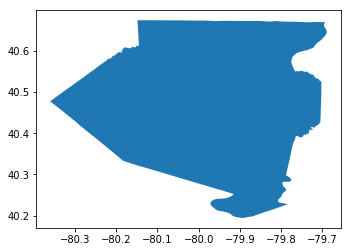

In [180]:
ac.plot()

In [181]:
ac.to_file('allegheny_county/allegheny_county.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/allegheny_county.geojson', 
                          'allegheny_county/allegheny_county.bin')

Read 1 features from allegheny_county/allegheny_county.geojson
1291 segments
Created allegheny_county/allegheny_county.bin (1291 segments)


# Zipcode boundaries

In [356]:
# List of Allegheny county zipcodes adapted from https://clicknathan.com/2012/10/10/csv-of-all-zip-codes-in-allegheny-county-and-pittsburgh/
ac_zips = [15006,15007,15101, 15006,15102,15014,15104,15015,15017,15106,15024,15025,15026,15108,15030,15046,15034,15110,15035,15112,15037,15044,15045,15116,15120,15126,15056,15129,15136,15130,15131,15132,15133,15135,15146,15064,15065,15137,15071,15139,15140,15201,15202,15203,15204,15205,15206,15207,15208,15209,15210,15211,15212,15213,15214,15215,15216,15217,15218,15219,15220,15221,15222,15223,15224,15225,15226,15227,15228,15229,15232,15233,15234,15235,15236,15237,15238,15239,15241,15242,15243,15275,15276,15142,15076,15143,15144,15084,15145,15147,15086,15122,15123,15090,15148]

In [ ]:
# Zipcode boundaries from http://openac-alcogis.opendata.arcgis.com/datasets/allegheny-county-zip-code-boundaries
z = gpd.read_file('allegheny_county/zip/Allegheny_County_Zip_Code_Boundaries.shp').to_crs(epsg=4326)
z.set_index('ZIP')

In [ ]:
z.plot()

In [363]:
z.to_file('allegheny_county/zip/allegheny_county_zips.geojson', driver="GeoJSON")
binarize_geojson_outlines('allegheny_county/zip/allegheny_county_zips.geojson', 
                          'allegheny_county/allegheny_county_zips.bin')

Read 122 features from allegheny_county/zip/allegheny_county_zips.geojson
53251 segments
Created allegheny_county/allegheny_county_zips.bin (53251 segments)


In [ ]:
us_zips = pd.read_csv("allegheny_county/zip/us-national-zips-2010.csv")
us_zips.set_index('zipcode')
pa_zips = us_zips[us_zips.state=='PA']
pa_zips

In [44]:
def output_zip_csv(df, zip_col, value_col, out_path):
    date_range = range(2010, 2012)
    out = open(out_path, 'w')
    # Write out header row.  First column is zipcode, then each year
    out.write("zip,%s\n" % (",".join(map(str,date_range))))
    for i in range(0,len(df.index)):
        zipcode = df[zip_col][i]
        val = df[value_col][i]
        row=[zipcode]
        for year in date_range:
            row.append(val)
        out.write('%s\n' % (",".join(map(str,row))))
    out.close()

In [ ]:
superzips_df = pd.read_excel('superzips/-revisedmurrayfile_111952895138.xls',header=6, dtype={'Zip code':numpy.str})
superzips_df

In [ ]:
list(superzips_df)

In [ ]:
ac_zips_gj = gpd.read_file('allegheny_county/zip/allegheny_county_zips.geojson')
ac_zips_gj


In [ ]:
ac_szs = pd.merge(superzips_df, ac_zips_gj, left_on='Zip code', right_on='ZIP', copy=True)
ac_szs

In [45]:
output_zip_csv(ac_szs,'Zip code','Centle score','superzips/ac_superzips_score.csv' )

In [46]:
output_zip_csv(ac_szs,'Zip code','Pct. of adults with BAs','superzips/ac_superzips_pct_bas.csv' )
output_zip_csv(ac_szs,'Zip code','Median family income in 000s of 2010$','superzips/ac_superzips_med_fam_inc.csv' )


In [29]:
pa_szs = pd.merge(superzips_df, ac_zips_gj, left_on='Zip code', right_on='zipcode', copy=True)

In [ ]:
pa_szs

In [36]:
output_zip_csv(pa_szs,'zipcode','Centle score','superzips/pa_superzips_score.csv' )

In [36]:
len(pa_zips[pa_zips.zipcode==15213])

1

In [38]:
len(z[z.ZIP=='15213'])

1

In [39]:
def compare_zips(property_zip, owner_zip):
    if(int(property_zip) == int(owner_zip)):
        return 'zip'
    elif(len(z[z.ZIP==str(owner_zip)])>0):
        return 'county'
    elif(len(pa_zips[pa_zips.zipcode==int(owner_zip)])>0):
        return 'state'
    else:
        return 'out-of-state'

In [41]:
compare_zips(15213,15213)

'zip'

In [42]:
compare_zips(15213,15012)

'county'

In [43]:
compare_zips(15213,'15712')

'state'

In [44]:
compare_zips('15213','68506')

'out-of-state'

# Census boundaries

In [125]:
#!wget https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_42003_tract10.zip
#!/usr/bin/ogr2ogr -f GeoJSON -t_srs crs:84 allegheny_county/tl_2010_42003_tract10.geojson allegheny_county/tl_2010_42003_tract10.shp

binarize_geojson_outlines('allegheny_county/tl_2010_42003_tract10.geojson',
                          'allegheny_county/allegeny_county_tracts_2010.bin')

Read 402 features from allegheny_county/tl_2010_42003_tract10.geojson
118186 segments
Created allegheny_county/allegeny_county_tracts_2010.bin (118186 segments)


In [126]:
#!/usr/bin/ogr2ogr -f GeoJSON -t_srs crs:84 allegheny_county/tl_2010_42003_bg10.geojson allegheny_county/tl_2010_42003_bg10.shp

binarize_geojson_outlines('allegheny_county/tl_2010_42003_bg10.geojson',
                          'allegheny_county/allegeny_county_blockgroups_2010.bin')

Read 1100 features from allegheny_county/tl_2010_42003_bg10.geojson
220899 segments
Created allegheny_county/allegeny_county_blockgroups_2010.bin (220899 segments)


In [127]:
#!/usr/bin/ogr2ogr -f GeoJSON -t_srs crs:84 allegheny_county/tl_2010_42003_tabblock10.geojson allegheny_county/tl_2010_42003_tabblock10.shp

binarize_geojson_outlines('allegheny_county/tl_2010_42003_tabblock10.geojson',
                          'allegheny_county/allegeny_county_blocks_2010.bin')

Read 30519 features from allegheny_county/tl_2010_42003_tabblock10.geojson
1141888 segments
Created allegheny_county/allegeny_county_blocks_2010.bin (1141888 segments)


In [128]:
def numpy_memmap_read(path, dtype):
    nelems = os.stat(path).st_size / numpy.dtype(dtype).itemsize
    return numpy.memmap(path, dtype=dtype, shape=(nelems,), mode='r')

numpy_memmap_read('allegheny_county/allegeny_county_tracts_2010.bin', numpy.float32)

memmap([ 71.16960907,  96.48995209,  71.1697464 , ...,  96.5345459 ,
        71.14060211,  96.5345993 ], dtype=float32)